Auslander *et al* ([*Nat. Med. 24(10):1545-1549*](https://www.nature.com/articles/s41591-018-0157-9)) derived the immuno-predictive score (IMPRES) by selecting 15 pairwise interactions between genes known to have biological function in the PD1-1 and/or CTLA-4 pathways from a total of 294 considered immune-interactions according to each feature's ability to identify spontaneously regressing neuroblastoma (NBL) samples in a custom machine learning framework.  Crucially, Auslander *et al* found that the original IMPRES features identified using only the NBL dataset were readily generalizable to predicting response to immune-checkpoint blockade (ICB) therapy in melanoma, providing excellent predictive power in 6 previously published datasets and a new melanoma dataset generated at MGH. 

We first replicate the ability of the 15 IMPRES features to predict melanoma responses:

In [1]:
import os, re,pdb
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score,roc_curve,recall_score,precision_score
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
def calculate_impres(df,gene_pairs):
    """
    Calculates the IMPRES score for an arbirtrary list of genes
    
    Inputs:
    (1) df-A pandas dataframe containing samples as rows and individual genes as columns and
    (2) gene_pairs- a list of pairwise interactions from which the score is calculated (e.g. list of IMPRES genes)
        * gene pairs are seperated by '_'
        
    Calculates interger score between 0 and the number of input features
    
    Outputs the original df with the score for each sample included as a new row (termed "IMPRES")
    
    """
    pairwise_interactions=pd.DataFrame(np.empty((df.shape[0],len(gene_pairs)),dtype=object),columns=gene_pairs,index=df.index)
    for feature in gene_pairs: #for each provided feature
        gene1,gene2=feature.split('_') #split provided gene1_gene2, where feature is gene1>gene2 by convention
        pairwise_interactions[feature]=np.array(1*(df[gene1].astype(float)>df[gene2].astype(float))) #for each sample, calculate if feature is present
    pairwise_interactions['IMPRES']=pairwise_interactions.sum(axis=1) #sum present features for each sample
    df = df.assign(IMPRES=pairwise_interactions.loc[df.index].IMPRES) #add score to df as new "IMPRES" column
    return df

In [3]:
def calculate_auc(df):
    """
    Calculate the receiver operator characteristic (ROC) curve and area under the curve (AUC)
    
    Input df created by "calculate_impres" defined above. Samples are rows, "IMPRES" column contains scores to use
    Input df must additionally contain a "Labels" column, which defines each sample as "Responder" or "NonResponder"
    
    ROC/AUC are calcualted using associated function from sklearn.metrics
    
    Output fpr,tpr for drawing ROC curves, AUC value, and number of responding/non-responding samples
    """
    responder=np.array(df[df.Labels=='Responder'].IMPRES) #IMPRES scores for Responder samples
    nonresponder=np.array(df[df.Labels=='NonResponder'].IMPRES) #IMPRES scores for NonResponder Samples
    fpr,tpr,threshold=roc_curve(np.hstack(([1]*len(responder),[0]*len(nonresponder))),np.hstack((responder,nonresponder))) #calculate ROC curve
    auc=np.round(roc_auc_score(np.hstack(([1]*len(responder),[0]*len(nonresponder))),np.hstack((responder,nonresponder))),2) #calculate AUC
    return fpr,tpr,auc,responder.shape[0],nonresponder.shape[0]

## Replicating the original IMPRES findings (Fig2)

We directly download the .mat files provided for each previously published melanoma dataset at the [Github repository](https://github.com/noamaus/IMPRES-codes) provided by Auslander *et al.*. The .mat files have been converted to python dataframes, but are otherwise unchanged.

Auslander *et al* additionally generated a new melanoma immunotherapy dataset (referred to as the MGH dataset). Matlab files are not provided for the MGH dataset, so we instead download it from GEO (GSE115821) and again convert it to python dataframes.

#### Slightly modified version of Fig2A from Auslander *et al*:

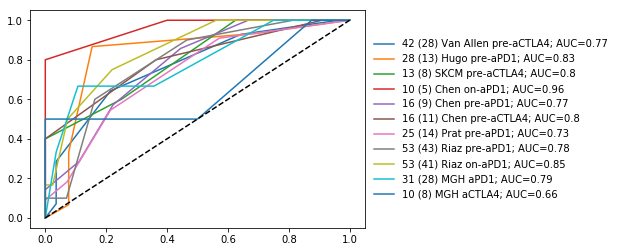

In [4]:
#The original IMPRES features given as gene1_gene2, defined as gene1>gene2:
impres=['CD274_C10orf54','CD86_CD200','CD40_CD274','CD28_CD276', 'CD40_CD28','TNFRSF14_CD86','CD27_PDCD1','CD28_CD86','CD40_CD80','CD40_PDCD1', 'CD80_TNFSF9','CD86_HAVCR2','CD86_TNFSF4', 'CTLA4_TNFSF4','PDCD1_TNFSF4']

fileroot='../Datasets/' #directory

#Dataset names for plotting, following the convention used in Fig2A-B
name=['Van Allen pre-aCTLA4','Hugo pre-aPD1','SKCM pre-aCTLA4','Chen on-aPD1','Chen pre-aPD1','Chen pre-aCTLA4','Prat pre-aPD1','Riaz pre-aPD1','Riaz on-aPD1','MGH aPD1','MGH aCTLA4']
for i,data in enumerate(['VanAllen','Hugo','SKCM','Wargo_onPD1','Wargo_prePD1','Wargo_preCTLA4','Felip','Riaz','Riaz_on','MGH_pd1','MGH_ctla4']): #for each dataset
    df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl') #load sequencing dataframe (converted from Auslander's .mat files)
    df=calculate_impres(df,impres) #Calculate IMPRES score
    fpr,tpr,auc,n_res,n_nres=calculate_auc(df) #Calculate AUC/ROC curves for each dataset using IMPRES
    plt.plot(fpr,tpr,label=f'{n_res+n_nres} ({n_nres}) {name[i]}; AUC={auc}') #Plot ROC curves, define labels
plt.plot([0,1],[0,1],'--k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
plt.show()
plt.close()

The previously published datasets (for which .mat files are provided) exactly reproduce Fig2A from the original paper. However, we note that the GEO MGH data produce very different ROC curves for the MGH datasets than that reported in Fig2B by Auslander *et al*. (AUC 0.97 vs 0.66 for MGH aCTLA4 and 0.81 vs. 0.79 for MGH aPD1). 

To explore this we below print the IMPRES features for each sample. IMPRES scores for the MGH dataset were not provided in the paper ([Sup Table 9](https://www.nature.com/articles/s41591-018-0157-9#Sec28)), but is given [here](https://github.com/noamaus/IMPRES-codes/issues/3). IMPRES scores there are different from those we find, but as far as I can tell, our scores are consistent with the MGH data downloaded from GEO:

In [5]:
def print_impres(df,gene_pairs): 
    """
    Modification of the calculate_impres definition to instead print the features that define the IMPRES score
    """
    pairwise_interactions=pd.DataFrame(np.empty((df.shape[0],len(gene_pairs)),dtype=object),columns=gene_pairs,index=df.index)
    pairwise_interactions_print=pd.DataFrame(np.empty((df.shape[0],len(impres)),dtype=object),columns=gene_pairs,index=df.index)
    for feature in gene_pairs:
        gene1,gene2=feature.split('_')
        pairwise_interactions[feature]=np.array(1*(df[gene1]>df[gene2]))
        pairwise_interactions_print[feature]=[str(x)+'/'+str(y)+' ('+str(1*(x>y))+')' for x,y in zip(df[gene1],df[gene2])]
    pairwise_interactions_print['IMPRES']=pairwise_interactions.sum(axis=1)
    display(pairwise_interactions_print)

In [6]:
for i,data in enumerate(['MGH_pd1','MGH_ctla4']):
    df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    print(data)
    df=print_impres(df,impres)

MGH_pd1


,CD274_C10orf54,CD86_CD200,CD40_CD274,CD28_CD276,CD40_CD28,TNFRSF14_CD86,CD27_PDCD1,CD28_CD86,CD40_CD80,CD40_PDCD1,CD80_TNFSF9,CD86_HAVCR2,CD86_TNFSF4,CTLA4_TNFSF4,PDCD1_TNFSF4,IMPRES
148-6-5-14_S9.bam,235.0/99.0 (1),443.0/23.0 (1),0.0/235.0 (0),128.0/122.0 (1),0.0/128.0 (0),36.0/443.0 (0),0.0/2.0 (0),128.0/443.0 (0),0.0/49.0 (0),0.0/2.0 (0),49.0/45.0 (1),443.0/417.0 (1),443.0/107.0 (1),12.0/107.0 (0),2.0/107.0 (0),6
208-3-11-15_S13.bam,56.0/121.0 (0),223.0/24.0 (1),0.0/56.0 (0),442.0/82.0 (1),0.0/442.0 (0),37.0/223.0 (0),13.0/14.0 (0),442.0/223.0 (1),0.0/21.0 (0),0.0/14.0 (0),21.0/244.0 (0),223.0/338.0 (0),223.0/88.0 (1),18.0/88.0 (0),14.0/88.0 (0),4
208-5-13-15_S14.bam,163.0/139.0 (1),269.0/19.0 (1),0.0/163.0 (0),272.0/31.0 (1),0.0/272.0 (0),19.0/269.0 (0),6.0/14.0 (0),272.0/269.0 (1),0.0/30.0 (0),0.0/14.0 (0),30.0/52.0 (0),269.0/243.0 (1),269.0/41.0 (1),65.0/41.0 (1),14.0/41.0 (0),7
39-10-31-14_S17.bam,123.0/85.0 (1),219.0/24.0 (1),0.0/123.0 (0),83.0/255.0 (0),0.0/83.0 (0),32.0/219.0 (0),11.0/49.0 (0),83.0/219.0 (0),0.0/46.0 (0),0.0/49.0 (0),46.0/93.0 (0),219.0/444.0 (0),219.0/75.0 (1),208.0/75.0 (1),49.0/75.0 (0),4
39-3-31-14_S15.bam,42.0/23.0 (1),141.0/6.0 (1),0.0/42.0 (0),208.0/153.0 (1),0.0/208.0 (0),49.0/141.0 (0),1.0/2.0 (0),208.0/141.0 (1),0.0/27.0 (0),0.0/2.0 (0),27.0/38.0 (0),141.0/212.0 (0),141.0/40.0 (1),14.0/40.0 (0),2.0/40.0 (0),5
39-8-25-14_S16.bam,82.0/93.0 (0),257.0/27.0 (1),1.0/82.0 (0),124.0/272.0 (0),1.0/124.0 (0),32.0/257.0 (0),3.0/10.0 (0),124.0/257.0 (0),1.0/29.0 (0),1.0/10.0 (0),29.0/32.0 (0),257.0/331.0 (0),257.0/77.0 (1),314.0/77.0 (1),10.0/77.0 (0),3
42-10-17-14_S3.bam,11.0/18.0 (0),57.0/2.0 (1),0.0/11.0 (0),52.0/81.0 (0),0.0/52.0 (0),25.0/57.0 (0),0.0/7.0 (0),52.0/57.0 (0),0.0/4.0 (0),0.0/7.0 (0),4.0/20.0 (0),57.0/48.0 (1),57.0/48.0 (1),9.0/48.0 (0),7.0/48.0 (0),3
42-11-24-14_S4.bam,312.0/206.0 (1),845.0/28.0 (1),0.0/312.0 (0),300.0/90.0 (1),0.0/300.0 (0),7.0/845.0 (0),19.0/85.0 (0),300.0/845.0 (0),0.0/70.0 (0),0.0/85.0 (0),70.0/28.0 (1),845.0/859.0 (0),845.0/103.0 (1),125.0/103.0 (1),85.0/103.0 (0),6
42-12-30-14_S5.bam,240.0/78.0 (1),427.0/14.0 (1),0.0/240.0 (0),257.0/59.0 (1),0.0/257.0 (0),37.0/427.0 (0),6.0/22.0 (0),257.0/427.0 (0),0.0/56.0 (0),0.0/22.0 (0),56.0/24.0 (1),427.0/401.0 (1),427.0/74.0 (1),51.0/74.0 (0),22.0/74.0 (0),6
MGH422-092815.bam,827.0/599.0 (1),591.0/147.0 (1),0.0/827.0 (0),122.0/1233.0 (0),0.0/122.0 (0),54.0/591.0 (0),41.0/247.0 (0),122.0/591.0 (0),0.0/141.0 (0),0.0/247.0 (0),141.0/423.0 (0),591.0/1062.0 (0),591.0/230.0 (1),131.0/230.0 (0),247.0/230.0 (1),4


MGH_ctla4


,CD274_C10orf54,CD86_CD200,CD40_CD274,CD28_CD276,CD40_CD28,TNFRSF14_CD86,CD27_PDCD1,CD28_CD86,CD40_CD80,CD40_PDCD1,CD80_TNFSF9,CD86_HAVCR2,CD86_TNFSF4,CTLA4_TNFSF4,PDCD1_TNFSF4,IMPRES
115-031814.bam,183.0/2913.0 (0),370.0/58.0 (1),0.0/183.0 (0),117.0/1324.0 (0),0.0/117.0 (0),406.0/370.0 (1),68.0/357.0 (0),117.0/370.0 (0),0.0/26.0 (0),0.0/357.0 (0),26.0/276.0 (0),370.0/678.0 (0),370.0/66.0 (1),78.0/66.0 (1),357.0/66.0 (1),5
115-041514.bam,755.0/1754.0 (0),964.0/362.0 (1),3.0/755.0 (0),434.0/1701.0 (0),3.0/434.0 (0),380.0/964.0 (0),148.0/1049.0 (0),434.0/964.0 (0),3.0/129.0 (0),3.0/1049.0 (0),129.0/218.0 (0),964.0/1363.0 (0),964.0/97.0 (1),472.0/97.0 (1),1049.0/97.0 (1),4
208-10-22-14_S12.bam,181.0/154.0 (1),473.0/12.0 (1),0.0/181.0 (0),336.0/85.0 (1),0.0/336.0 (0),24.0/473.0 (0),11.0/30.0 (0),336.0/473.0 (0),0.0/46.0 (0),0.0/30.0 (0),46.0/57.0 (0),473.0/613.0 (0),473.0/103.0 (1),154.0/103.0 (1),30.0/103.0 (0),5
208-9-10-14_S11.bam,20.0/64.0 (0),86.0/14.0 (1),0.0/20.0 (0),151.0/88.0 (1),0.0/151.0 (0),64.0/86.0 (0),0.0/1.0 (0),151.0/86.0 (1),0.0/13.0 (0),0.0/1.0 (0),13.0/74.0 (0),86.0/89.0 (0),86.0/30.0 (1),3.0/30.0 (0),1.0/30.0 (0),4
MGH272-020415.bam,1528.0/3929.0 (0),1457.0/287.0 (1),3.0/1528.0 (0),699.0/2287.0 (0),3.0/699.0 (0),50.0/1457.0 (0),415.0/1511.0 (0),699.0/1457.0 (0),3.0/193.0 (0),3.0/1511.0 (0),193.0/155.0 (1),1457.0/3456.0 (0),1457.0/377.0 (1),621.0/377.0 (1),1511.0/377.0 (1),5
MGH272-121914.bam,1144.0/3632.0 (0),1270.0/320.0 (1),6.0/1144.0 (0),465.0/2649.0 (0),6.0/465.0 (0),48.0/1270.0 (0),297.0/1494.0 (0),465.0/1270.0 (0),6.0/187.0 (0),6.0/1494.0 (0),187.0/227.0 (0),1270.0/3683.0 (0),1270.0/735.0 (1),411.0/735.0 (0),1494.0/735.0 (1),3
MGH422-092815.bam,827.0/599.0 (1),591.0/147.0 (1),0.0/827.0 (0),122.0/1233.0 (0),0.0/122.0 (0),54.0/591.0 (0),41.0/247.0 (0),122.0/591.0 (0),0.0/141.0 (0),0.0/247.0 (0),141.0/423.0 (0),591.0/1062.0 (0),591.0/230.0 (1),131.0/230.0 (0),247.0/230.0 (1),4
MGH422-110515.bam,694.0/4850.0 (0),1061.0/282.0 (1),3.0/694.0 (0),3720.0/158.0 (1),3.0/3720.0 (0),164.0/1061.0 (0),982.0/2961.0 (0),3720.0/1061.0 (1),3.0/256.0 (0),3.0/2961.0 (0),256.0/58.0 (1),1061.0/1093.0 (0),1061.0/350.0 (1),2183.0/350.0 (1),2961.0/350.0 (1),7
62-10-2-13_S6.bam,46.0/48.0 (0),111.0/8.0 (1),0.0/46.0 (0),161.0/138.0 (1),0.0/161.0 (0),33.0/111.0 (0),1.0/3.0 (0),161.0/111.0 (1),0.0/18.0 (0),0.0/3.0 (0),18.0/122.0 (0),111.0/88.0 (1),111.0/33.0 (1),15.0/33.0 (0),3.0/33.0 (0),5
62-5-27-14_S7.bam,53.0/86.0 (0),139.0/4.0 (1),1.0/53.0 (0),188.0/235.0 (0),1.0/188.0 (0),45.0/139.0 (0),2.0/3.0 (0),188.0/139.0 (1),1.0/15.0 (0),1.0/3.0 (0),15.0/97.0 (0),139.0/117.0 (1),139.0/13.0 (1),7.0/13.0 (0),3.0/13.0 (0),4


Per our correspondence with Auslander *et al.*, the AUC values reported for the MGH dataset in Fig2B were calculated using RPKM values while the GEO provides raw counts. As IMPRES was reported to function independent of paramaterization (*e.g.* the original IMPRES score for the Riaz *et al.* dataset was calculated using raw counts), this discrepancy was surprising to us. 

Nevertheless, IMPRES appears to still predict immunotherapy response at rates better than random in the MGH dataset and confirms our ability to here replicate the original findings. 

### Impact of transcriptome paramaterization on IMPRES

To further investigate the impact of transcriptome parameterization on IMPRES performance, we obtained raw RNA-sequencing data for the pre-immunotherapy melanoma samples from Hugo, Riaz and Van Allen *et al.*. We next used Kallisto to qunatify RNA expression as transcripts per million (TPM) before applying IMPRES:

In [7]:
#Download TPM dataframes for each melanoma sample
hugo=pd.read_csv(fileroot+'TPM Datasets/Hugo_tpm.csv') #Hugo pre-therapy
hugo.index=np.array(hugo['sample'])
hugo=hugo.drop(columns=['sample'])
riaz=pd.read_csv(fileroot+'TPM Datasets/Riaz_tpm.csv') #Riaz pre-therapy
riaz.index=np.array(riaz['sample'])
riaz=riaz.drop(columns=['sample'])
vanallen=pd.read_csv(fileroot+'TPM Datasets/vanallen_tpm.csv') #Van Allen pre-therapy
vanallen.index=np.array(vanallen['sample'])
vanallen=vanallen.drop(columns=['sample'])

In [8]:
#download metadata file
reference_df=np.genfromtxt(fileroot+'TPM Datasets/Melanoma_metadata.txt',dtype='unicode',delimiter='\t',)
reference_df=pd.DataFrame(reference_df)
reference_df.columns=reference_df.iloc[0]
reference_df=reference_df[1:]

#Define responders/non-responders from RECIST criteria 
response=['Partial Response','Complete Response']
no_response=['Progressive Disease','Stable Disease']
reference_df['Outcome']=['Responder' if x in response  else 'NonResponder' for x in reference_df.RECIST]

#dict to take transcript id to gene name, downloaded from Ensembl
transcripts_to_gene=pd.DataFrame(np.genfromtxt(fileroot+'TPM Datasets/Map_transcripts_gene.txt',dtype='unicode',delimiter='\t')[1:],columns=['Gene_ID','Transcript_ID','Gene_name','Transcript_name','Gene_ID_version','Transcript_ID_version'])
transcripts_to_gene.index=transcripts_to_gene.Transcript_ID_version

In [9]:
#C10or54==VSIR
impres_tpm=['CD274_VSIR','CD86_CD200','CD40_CD274','CD28_CD276', 'CD40_CD28','TNFRSF14_CD86','CD27_PDCD1','CD28_CD86','CD40_CD80','CD40_PDCD1', 'CD80_TNFSF9','CD86_HAVCR2','CD86_TNFSF4', 'CTLA4_TNFSF4','PDCD1_TNFSF4']
impres_features=np.unique([x.split('_') for x in impres_tpm])

In [10]:
#Calculate IMPRES using values from Kallisto
hugo=calculate_impres(hugo,impres_tpm)
riaz=calculate_impres(riaz,impres_tpm)
vanallen=calculate_impres(vanallen,impres_tpm)

#Add "Labels" column with outcome for each patient
hugo['Labels']=[np.array(reference_df[reference_df.Tumor_RNA==x].Outcome)[0] for x in hugo.index]
riaz['Labels']=[np.array(reference_df[reference_df.Tumor_RNA==x].Outcome)[0] for x in riaz.index]
vanallen['Labels']=[np.array(reference_df[reference_df.Tumor_RNA==x].Outcome)[0] for x in vanallen.index]

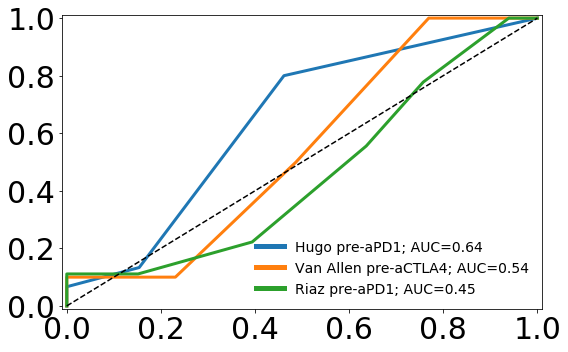

In [11]:
#Plot ROC curve for each TPM sample
plt.figure(figsize=(8,5))
name=['Hugo pre-aPD1','Van Allen pre-aCTLA4','Riaz pre-aPD1'] #name for legend
for i,df in enumerate([hugo,riaz,vanallen]): #for each tpm dataset
    fpr,tpr,auc,n_res,n_nres=calculate_auc(df)  #calculate ROC curve
    plt.plot(fpr,tpr,label=f'{name[i]}; AUC={auc}',lw=3)
plt.plot([0,1],[0,1],'--k')
leg=plt.legend(loc='lower right',frameon=False,fontsize=14) 
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.ylim([-0.01,1.01])
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig('./Letter_SFig4A'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

Mann Whitney p values:
0.09366664973791278
0.34046087834088107
0.3422589536851421


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


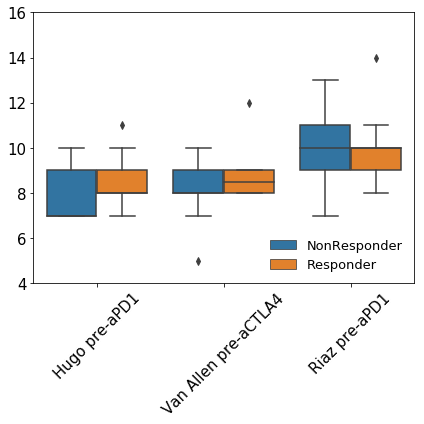

In [12]:
#Average IMPRES score for responder/nonresponder groups using TPM values
print('Mann Whitney p values:')
for i,data in enumerate([hugo,riaz,vanallen]):
    df=data[['IMPRES','Labels']]
    df['Dataset']=np.array([name[i]]*df.shape[0])
    #Mann Whitney p value
    print(stats.mannwhitneyu(df[df.Labels=='Responder'].IMPRES,df[df.Labels=='NonResponder'].IMPRES)[1])
    if i==0:
        all_df=df
    else:
        all_df=all_df.append(df)
        
#Boxplot with AUC values for TPM datasets
plt.figure(figsize=(6,6))
sns.boxplot(x='Dataset',y='IMPRES',hue='Labels',data=all_df)
plt.legend(frameon=False,fontsize=13,loc='lower right')
plt.ylim([4,16])
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15,rotation=45)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./Letter_SFig4D'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()


Surprisingly, our resutls suggest that the success of IMPRES in predicting melanoma response to ICB response is dependent on the trancriptome parameterization for each dataset. Specifically, reparameterizing these datasets to TPM values negates the predictive power of IMPRES. If IMPRES is able to describe meaningful biological relationships, they should not depend on dataset parameterization. One possible explanation of this is that IMPRES has been overfit to the melanoma datasets. 

Returning to the original datasets used by Auslander *et al.*, we further confirm our ability to replicate the original IMPRES findings. Next examining all melanoma samples together:

In [13]:
immunotherapy_type=[]
#Combine the independent datasets into all_data dataframe
for i,data in enumerate(['VanAllen','Hugo','SKCM','Wargo_onPD1','Wargo_prePD1','Wargo_preCTLA4','Felip','Riaz','Riaz_on','MGH_PD1','MGH_CTLA4']):
    add_df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    if i==0:
        all_data=add_df
    else: 
        all_data=all_data.append(add_df)
    if data in ['VanAllen','Wargo_preCTLA4','MGH_CTLA4','SKCM']: #CTLA datasets
         immunotherapy_type.append(['CTLA4']*add_df.shape[0])
    else: #PD1 dataset
        immunotherapy_type.append(['PD1']*add_df.shape[0])
all_data['immunotherapy_type']=np.hstack(immunotherapy_type) #Within all_data, PD1 or CTLA4 is given under "immunotherapy_type" column
all_data.index=[str(i)+x for i,x in enumerate(all_data.index)] #Index is sample name. Add sample position to ensure each sample name is unique (i.e. no collisions between datasets)

#### Slightly modified version of Fig2B:

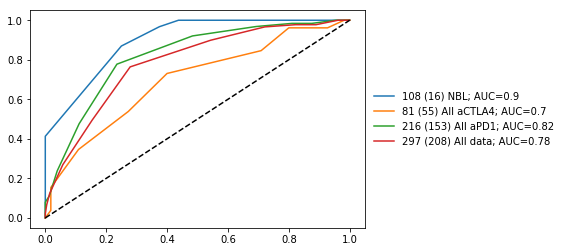

In [14]:
name=['NBL','All aCTLA4','All aPD1','All data'] #Names for figure legend
for i,data in enumerate(['NBL','CTLA4','PD1','All']): #Draw ROC curves for NBL dataset, all samples for melanoma therapy type, or all melanoma datasets together
    if data=='All': #All melanoma datasets
        df=all_data
    elif data=='NBL': #NBL dataset (used for IMPRES training, not indpendent)
        df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    else: #All PD1 or CLTA4 samples together
        df=all_data[all_data.immunotherapy_type==data]
    df=calculate_impres(df,impres) #calculate IMPRES score
    fpr,tpr,auc,n_res,n_nres=calculate_auc(df) #Calcualte ROC/AUC
    plt.plot(fpr,tpr,label=f'{n_res+n_nres} ({n_nres}) {name[i]}; AUC={auc}') #plot ROC curves w/ label
plt.plot([0,1],[0,1],'--k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False)
plt.show()
plt.close()

Note that the differences in AUC between this and the reported values (Fig2B) likely stem from the the use of raw counts in the MGH sample rather than RPKM. 

Additionally note that there appears to be a typo in the legend for Fig2B in the original IMPRES article. Auslander *et al* report counts of 81 (28) for all CTLA4, 216 (28) for PD1 and 297 (208) for all combined. This appears to be a mistake as $28+28\neq208$.

We additionally observe that IMPRES predicts spontaneous regression in NBL patients with an AUC$\approx$0.90. An important note here is that the NBL is identical to that used to train IMPRES (*i.e.* the NBL data is not an independent test set). Consequently, we would expect that the greedy algorithm used to select the IMPRES features should directly maximize the predictive power for the NBL training set. As such, we were suprised to find that IMPRES had only slightly better predictions on the NBL dataset as compared to the independent melanoma datasets (AUC=0.78 here, but an AUC of 0.83 was reported in the original manuscript. 

#### Additionally replicating Fig2C:

In [15]:
#Code for multiple, stacked baroplots modified from:
    #https://gitlab.com/ciraig/lca_standard_graphs/tree/master
    #BSD 2-clause license
    
#Shown here for convience rather than importing as seperate class

def build_comparison_table(dfs, names, fillna=None, column_name='Scenarios'):
    for i, df in enumerate(dfs):
        # Add the name of each dataframe for disambiguation
        df.insert(0, column_name, names[i], allow_duplicates=True)

    # Concatenate
    comp = pd.concat(dfs, sort=False)
    comp.sort_index(inplace=True)
    comp.set_index(column_name, append=True, inplace=True)

    if fillna is not None:
        comp.fillna(fillna, inplace=True)

    return comp

def plot_grouped_stackedbars(df, ix_categories, ix_entities_compared, norm='max', err_pos=None, err_neg=None,
                             palette_def=('pastel', 'deep', 'dark'), width=0.3, figsize=(8, 4), xaxis_label=''):

    # Hardcoded
    edgecolor = 'k'
    transparent = (0, 0, 0, 0)

    # Test that there are not too many entities compared.
    if len(df.index.get_level_values(ix_entities_compared).unique()) > 3:
        print("Warning. Too many entities being compared. Please use `plot_grouped_stackedbars_wlargegroups()` instead.")
        return None

    # Normalize
    if norm is not None:
        if norm == 'max':
            df = _normalize_impacts(df, ix_categories, ix_entities_compared,
                                    donotsumbutnormalize=(err_neg, err_pos))
        else:
            df = _normalize_impacts(df, ix_categories, ix_entities_compared, ref=norm,
                                    donotsumbutnormalize=(err_neg, err_pos))

    # Initializations. Creates two subplots, the first one (ax) for the actual figure, and the second (ax2) as dummy to
    # display the legend without this legend overlapping with the plot but still within the bounds of the figure.
    # width_ratios is dummy ratio to make second plot very small
    fig, (ax, ax2) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[100, 1]},
                                  facecolor='white', figsize=figsize)
    # make dummy axis disapear
    ax2.get_yaxis().set_ticks([])
    ax2.axis('off')

    # All compared entities, in order of appearance
    all_entities = df.index.get_level_values(ix_entities_compared).unique()
    all_contributions = [i for i in df.columns if i not in [err_neg, err_pos]]

    # Determine number of entities, portions, and colors
    n_entities_compared = len(all_entities)
    n_palettes = len(palette_def)

    # Define palettes
    palettes = []
    if n_entities_compared <= n_palettes:
        for i in range(n_palettes - n_entities_compared, n_palettes):
            palettes += [sns.color_palette(palette_def[i])]
    else:
        palettes = None
    # Loop over all entities compared

    for i, ent in enumerate(all_entities):

        # Subset of contribution data for this loop
        sub = df.xs(ent, axis=0, level=ix_entities_compared)[all_contributions]

        if err_pos:
            # Error bar data fro this loop, if applicable
            err = df.xs(ent, axis=0, level=ix_entities_compared)[[err_neg, err_pos]].values.T
        else:
            err = None

        # Plot horizontal bar
        sub.plot.barh(ax=ax, stacked=True, position=i, width=width, zorder=-1,
                      color=palettes[i], edgecolor=edgecolor, label='_nolegend_')

        # Plot over this bar with a transparent bar, to add the confidence interval
        sub.sum(1).plot.barh(ax=ax, position=i, width=width, color=transparent, xerr=err, label='_nolegend_')

        if i == n_entities_compared - 1:

            # Generate the legend complement explaining about shading
            legend_elements = _generate_legend(all_entities)

            # Integrate in legend and plot legend
            handles, labels = ax.get_legend_handles_labels()
            handles2 = handles[-len(all_contributions):] + legend_elements

    # Legend definition (hidden in first subplot, but displayed in second)
    ax.get_legend().remove()
    #ax2.legend(handles=handles2, loc='center left', bbox_to_anchor=(0, 0.5))
    ax2.legend('',frameon=False)
    # Axis title
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
    ax.xaxis.set_label_text(xaxis_label)
    ax.yaxis.set_label_text('')
    
    # Rescale
    ax.autoscale()  # Important to not have the bars come right up to th edge of figure
    fig.tight_layout() # Important to not have labels and legend extend beyond figure

    return ax, fig

def _generate_legend(entities):
    legend_elements = []

    if len(entities) > 3:
        legend_elements += [Patch(edgecolor='black',
                                  facecolor='white',
                                  label="Gradient: {} (lightest), {}, {} (darkest)".format(entities[0],
                                                                                           ', '.join(entities[1: -1]),
                                                                                           entities[-1]))]
    else:

        legend_elements += [Patch(edgecolor='black',
                                  facecolor='white',
                                  label='light colors: ' + entities[0])]
        if len(entities) == 3:
            legend_elements += [Patch(edgecolor='black', 
                                      facecolor='white', 
                                      label='medium colors: ' + entities[1])]

        legend_elements += [Patch(edgecolor='black', 
                                  facecolor='white', 
                                  label='dark colors: ' + entities[-1])]
    return legend_elements

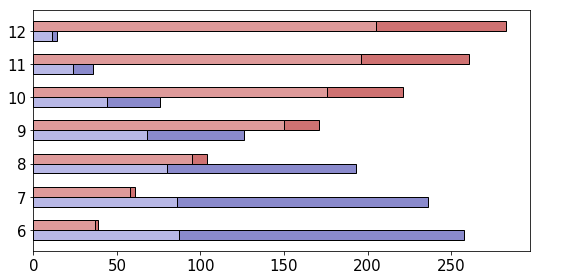

In [16]:
df=all_data #Use all melanoma samples regardless of therapy type
df=calculate_impres(df,impres) #calculate impress scores for each melanoma sample
data=[]
for threshold in range(6,13): #At thresholds between 6 an 12, calculate true positives (TP,light blue), 
        #false positives (FP, dark blue), true negatives (TN, light red), and false negatives (FN, dark red) 
    TP=df[(df.Labels=='Responder') & (df.IMPRES>=threshold)].shape[0] #Use >=threshold
    FP=df[(df.Labels=='NonResponder') & (df.IMPRES>=threshold)].shape[0]
    FN=df[(df.Labels=='Responder') & (df.IMPRES<threshold)].shape[0]
    TN=df[(df.Labels=='NonResponder') & (df.IMPRES<threshold)].shape[0]
    data.append([threshold,TP,FP,FN,TN])
df=pd.DataFrame(data,columns=['Threshold','TP','FP','FN','TN'])
df1=df[['TP','FP']] #process data per https://gitlab.com/ciraig/lca_standard_graphs/tree/master
df2=df[['TN','FN']]
df2.columns=['TP','FP']
df1.index=df.Threshold
df2.index=df.Threshold
comp = build_comparison_table([df2, df1], ['Positive', 'Negative'], fillna=0.0)
#Plot grouped/stacked barplots
ax, fig = plot_grouped_stackedbars(comp, ix_categories='Criteria', ix_entities_compared='Scenarios', norm=None,palette_def=[sns.light_palette("firebrick")[-4::],sns.light_palette("navy")[-5::]])

#### And Fig2D:

In [17]:
#Calculate recall and precision scores using sklearn
data=[]
df=all_data
df=calculate_impres(df,impres)
for threshold in range(5,14):
    r=recall_score([1 if x=='Responder' else 0 for x in df.Labels],[1 if x>=threshold else 0 for x in df.IMPRES])
    p=precision_score([1 if x=='Responder' else 0 for x in df.Labels],[1 if x>=threshold else 0 for x in df.IMPRES])
    data.append([threshold,r,p])
df=pd.DataFrame(np.vstack((data)),columns=['Score','Recall','Precision'])

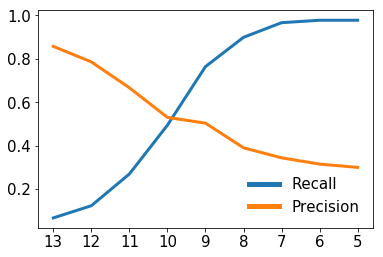

In [18]:
#Plot recall/precision curves
plt.plot(np.array(df.Score.astype(str)[::-1]),np.array(df.Recall.astype(float)[::-1]),label='Recall',lw=3)
plt.plot(np.array(df.Score.astype(str)[::-1]),np.array(df.Precision.astype(float)[::-1]),label='Precision',lw=3)
leg=plt.legend(frameon=False,fontsize=15)
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.yticks(fontsize=15)
plt.xticks(np.arange(9),np.arange(5,14)[::-1],fontsize=15)
plt.show()
plt.close()

Examining the ability of IMPRES to differentiate survival outcomes in melanoma:

#### Fig2E:

In [19]:
def kaplan_meier(data,gene_set,fig=None):
    df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    df=calculate_impres(df,gene_set)
    if data=='Riaz':
        df2=pd.read_pickle(fileroot+'/Auslander/'+data+'_on_data.pkl')
        df2=calculate_impres(df2,gene_set)
        df=df.append(df2)
        
    sample = np.genfromtxt(fileroot+'/Survival/'+data+'_surv_sample.txt',dtype='unicode')
    survival = np.genfromtxt(fileroot+'/Survival/'+data+'_survival',dtype='unicode')
    death=np.genfromtxt(fileroot+'/Survival/'+data+'_death',dtype='unicode')
    
    survdf=pd.DataFrame(np.vstack((survival,death)).T,index=sample)
    survdf.columns=['Survival','Death']
    survdf['IMPRES']=df.loc[survdf.index].IMPRES
    

    
    threshold=np.percentile(survdf.IMPRES,50).astype(int)
    
    kmf = KaplanMeierFitter()
    kmf.fit(survdf[survdf.IMPRES.astype(float)>threshold].Survival.astype(int),event_observed=1-survdf[survdf.IMPRES.astype(float)>threshold].Death.astype(int),label='High') 

    print(survdf[survdf.IMPRES.astype(float)>threshold].shape)
    
    kmf2 = KaplanMeierFitter()
    kmf2.fit(survdf[survdf.IMPRES.astype(float)<=threshold].Survival.astype(int),event_observed=1-survdf[survdf.IMPRES.astype(float)<=threshold].Death.astype(int),label='Low') 
    
    print(survdf[survdf.IMPRES.astype(float)<=threshold].shape)
    
    ax=kmf.plot(c='dodgerblue')
    ax = kmf2.plot(ax=ax,c='orangered')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('')
    leg=plt.legend(frameon=False,fontsize=15)
    sns.despine()
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    
    if fig!=None:
        plt.tight_layout()
        plt.savefig('./'+fig+'.png',format='png', dpi=1200,transparent=True)
    
    results = logrank_test(survdf[survdf.IMPRES.astype(float)>threshold].Survival.astype(int), survdf[survdf.IMPRES.astype(float)<=threshold].Survival.astype(int), 1-survdf[survdf.IMPRES.astype(float)>threshold].Death.astype(int), 1-survdf[survdf.IMPRES.astype(float)<=threshold].Death.astype(int), alpha=.99)
    results.print_summary()

#### Fig2E (Van Allen *et al.*):

(15, 3)
(27, 3)
<lifelines.StatisticalResult>
               t_0 = -1
             alpha = 0.99
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  log(p)   
          8.63 <0.005   -5.71  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


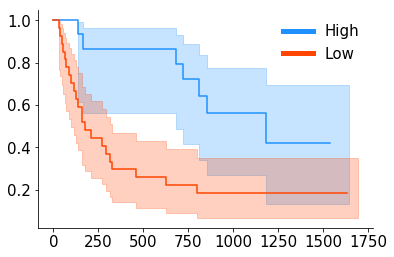

In [20]:
kaplan_meier('VanAllen',impres)

#### Fig2F (Riaz *et al.*):

(16, 3)
(42, 3)
<lifelines.StatisticalResult>
               t_0 = -1
             alpha = 0.99
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  log(p)   
          9.69 <0.005   -6.29  *
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


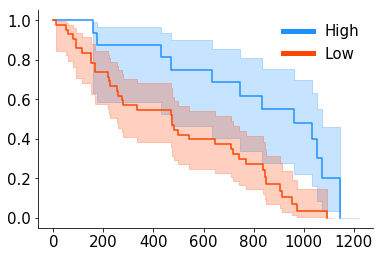

In [21]:
kaplan_meier('Riaz',impres)

And looking at progression free survival:

#### Fig2G (Van Allen *et al.*):

In [22]:
def pfs_plot(data,gene_set,fig=None):
    sample = np.genfromtxt(fileroot+'/Survival/'+data+'_surv_sample.txt',dtype='unicode')
    survival = np.genfromtxt(fileroot+'/Survival/'+data+'_surv_PFS',dtype='unicode',delimiter=',')
    df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    df=calculate_impres(df,gene_set)
    survdf=pd.DataFrame(np.vstack((survival,sample)).T,index=sample,columns=['PFS','Sample'])
    survdf['IMPRES']=df.loc[survdf.index].IMPRES
    threshold=np.percentile(survdf.IMPRES,50).astype(int)
    survdf['Group']=[1 if x>=threshold else 0 for x in survdf.IMPRES]
    survdf[['Group','PFS']]=survdf[['Group','PFS']].astype(float)
    print(np.unique(survdf.Group,return_counts=1)[1])
    np.unique(survdf.Group,return_counts=1)
    sns.boxplot(x='Group',y='PFS',data=survdf,palette=['Salmon','Dodgerblue'])
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(np.arange(2),['Low','High'],fontsize=20)
    plt.yticks(fontsize=15)
    if fig!=None:
        plt.tight_layout()
        plt.savefig('./'+fig+'.png',format='png', dpi=1200,transparent=True)
        plt.ylim([0,40])
    plt.show()
    plt.close()
    print(f'p value: {stats.ranksums(survdf[survdf.Group==0].PFS,survdf[survdf.Group==1].PFS)[1]/2}')

[15 27]


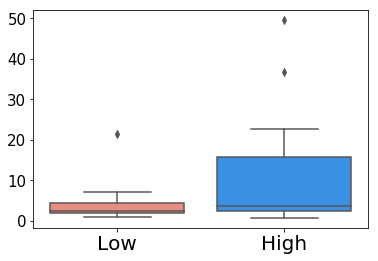

p value: 0.03026773965532459


In [23]:
pfs_plot('VanAllen',impres)

#### Fig2H (Prat *et al.*):

[ 7 18]


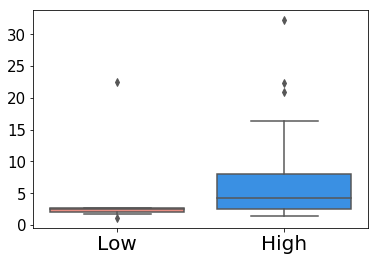

p value: 0.05111742236774389


In [24]:
pfs_plot('Felip',impres)

## Detailed examination of the IMPRES algorithm

Auslander *et al* begun by identifying 28 immune-checkpoint related genes from the literature, of which they determined that 6 (CTLA-4,CD28,CD80,CD86,PD-1, and PD-L1) were directly associated the either PD-1 or CTLA-4 pathways. Accordingly, there are 294 possible pairwise interactions that were considered for incorporation into IMPRES. Working under the hypothesis that the immune features mediating spontaneous NBL regression and melanoma response to immune-checkpoint blockade (ICB) therapy are conserved, Auslander *et al* perform feature selection using the following custom algorithm:

1. Randomly select 13 out of 92 spontaneously regressing NBL samples and 13 out of 16 non-regressing NBL samples as a training set. 3 of the remaining 79 regressing and the 3 remaining non-regressing samples are then used as an independent validation set. 
2. Within the training data, calculate the area under the receiver operator characteristic curve (AUC) for each of the possible 294 pairwise interactions. Greedily incorporate the set of features which gives the greatest increase in AUC (*i.e.* if *n* features give the same AUC, add all *n* features)
3. Repeat Step 2 until the training AUC is 1, up to a maximum of 15 incorporation steps.
4. Repeat Steps 1-3 independently for 500 iterations.  
5. For each pairwise interaction, subtract the number of unsuccessful iterations (validation AUC$\leq$0.4) from the number of successful iterations (validation AUC$\geq$0.6) that contain each of the 294 features. 
6. The top 5\% of features as defined in Step 5 are then combined into a final feature set, which is termed IMPRES. 


In [25]:
#The 28 considered immune genes:
immune_genes=['BTLA','C10orf54','CD200','CD200R1','CD27','CD274','CD276','CD28','CD40','CD80','CD86','CEACAM1','CTLA4','HAVCR2','IDO1','IL2RB','LAG3','PDCD1','PDCD1LG2','PVR','PVRL2','TIGIT','TNFRSF14','TNFRSF18','TNFRSF4','TNFRSF9','TNFSF4','TNFSF9']

#The 6 defined to have direct biological function in PD1 and/or CTLA4 pathways
checkpoint=['CTLA4','CD28','CD80','CD86', 'PDCD1','CD274']

impres_consider=[]
impres_consider_directionless=[]
for i,x in enumerate(immune_genes): #Enumerates all 294 possible features that IMPRES considers
    for y in immune_genes[i+1:]:
        if x in checkpoint or y in checkpoint:
            impres_consider_directionless.append([x,y])
            impres_consider.append([x,y])
            impres_consider.append([y,x])
impres_consider=np.array(impres_consider) #294 directed features that were considered for IMPRES

### Information theoretic analyses

To better understand the relatively low predictive success of IMPRES in NBL, we next examined the relationship between each of the IMPRES features and the NBL dataset. Recall that IMPRES feature selection was performed by considering the set of possible pairwise interactions between 28 immune-related genes and 6 PD1/CTLA pathway genes, giving 147 (directionless) possible combinations. Accounting for the directionality of each pairwise relationship (e.g. x>y is different from y>x), Auslander *et al* examined a total set of 294 total possible features. 

To understand the 15 features that were selected relative to the remaining 279, we used an information theoretic approach and calculated the mutual information ($I$) between each feature individually ($f$) and NBL outcome ($R$) as:

$$
\begin{array}
\
I(R|f)&=&\displaystyle \sum_{r \in R} \sum_{f \in F}  p(r,f) \log_2 \frac{p(r,f)}{p(r)p(f)}
\end{array}
$$


$I$ thus provides a theoretic measure for the amount of information that a particular feature contains about NBL outcome. 

The greedy hill-climbing algorithm used to select the IMPRES features can be thought of as a numerical method for iteratively estimating the feature that best seperates regressing from non-regressing NBL patients. Mathematically, each round of the algorithm selects feature $f_i$, where $\vec\theta=\left\{ f_0..f_{i-1} \right\}$ and represents the set of features selected in previous iterations, according to:

$$
\begin{array}
\
f_i &=&\displaystyle \max \limits_{f \in F \setminus \vec\theta} \left\{ I(R| \vec\theta + f) \right\}
\end{array}
$$

Note that $F \setminus \vec\theta$ ($F$ set minus $\vec\theta$) prevents the same feature from being selected more than once. 

While the greedy nature of Auslander algorithm means that incorporation of features depend on those selected in previous iterations. In this way, synergy and redudancy between various features (*i.e.* second and third order interactions) entails that 

$$
\begin{array}
\
I(R| \vec\theta)  &\neq&\displaystyle \sum\limits_{f \in \vec\theta} I(R|f) 
\end{array}
$$


Nevertheless, features should be incorporated in rough approximation to the amount of information they provide about NBL regression. Calculating the first-order mutual information for each feature, we find:

In [26]:
def calculate_MI(values,labels): #Calculates mutual information (MI)
    a=(np.where((values==1) & (labels==1))[0].shape[0]) #Responders with feature
    b=(np.where((values==1) & (labels==0))[0].shape[0]) #Nonresponders with feature
    c=(np.where((values==0) & (labels==1))[0].shape[0]) #Responders without feature
    d=(np.where((values==0) & (labels==0))[0].shape[0]) #Nonresponders without feature
    a,b,c,d=[x/len(values)+1e-12 for x in [a,b,c,d]] #Normalize and then add infinitesimally small value to avoid zeros in division
    I=sum([(p_rf*np.log2(p_rf/(p_r*p_f))) for p_rf,p_r,p_f in zip([a,b,c,d],[a+b,a+b,c+d,c+d],[a+c,b+d,a+c,b+d])]) #MI
    return I

In [27]:
I=[]
regression,nonregression=pd.read_pickle(fileroot+'Auslander'+'/NBL_res.pkl'),pd.read_pickle(fileroot+'Auslander'+'/NBL_nres.pkl') #load NBL data
for x,y in impres_consider:
    values=np.hstack((1*(regression[x]>regression[y]),1*(nonregression[x]>nonregression[y])))
    labels=np.hstack(([1]*regression.shape[0],[0]*nonregression.shape[0]))
    if len(np.unique(values))==2:
        I.append(calculate_MI(values,labels))
    else:
        I.append(0)
df=pd.DataFrame(I,index=[x+'_'+y for x,y in impres_consider],columns=['I']).sort_values(by='I',ascending=0)

Note that $I(R|f)$ contains the same amount of information for $f=X>Y$ and $f=Y>X$. So, we will use the IMPRES directionality when possible, otherwise don't consider direction.

In [28]:
features_directionless=[x+'_'+y for x,y in impres_consider_directionless] #147 features not considering direction
impres_inverse=[x.split('_')[1]+'_'+x.split('_')[0] for x in impres] #Flip IMPRES directionality
features=np.hstack((np.setdiff1d(features_directionless,impres_inverse),np.setdiff1d(impres,features_directionless))) #features to use

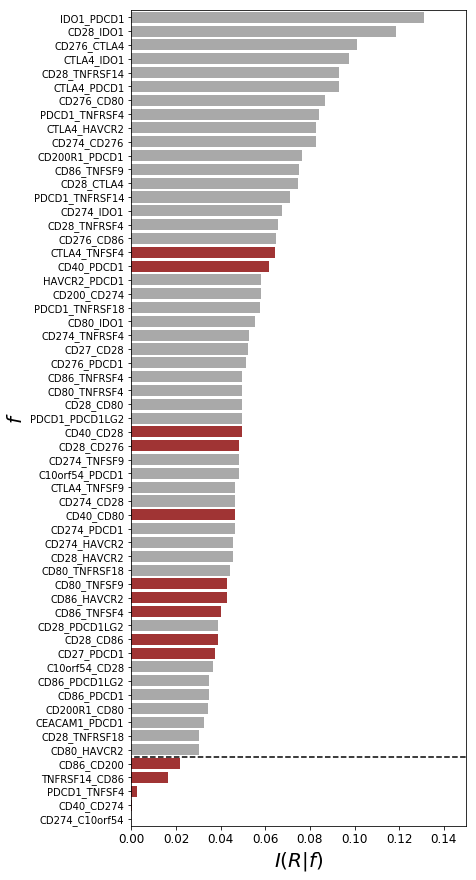

In [29]:
plt.figure(figsize=(6,15))
threshold=0.03 #threshold to plot feature not in impres
data=df.loc[features] #consider feature directionality
data=data[(data.index.isin(impres)) | (data.I>threshold)].sort_values(by='I',ascending=0) #Include IMPRES features, remove IMPRES inverse
plt.plot([-1,1],[np.where(data.I<threshold)[0][0]-.5,np.where(data.I<threshold)[0][0]-.5],'--k')
ax=sns.barplot(y=data.index,x=data.I,palette=['Firebrick' if x in impres else 'DarkGray' for x in data.index])
plt.yticks(fontsize=10)
plt.xticks(fontsize=12)
plt.xlabel(r'$I(R|f)$',fontsize=20)
plt.ylabel(r'$f$',fontsize=20)
plt.xlim([0,.15])
plt.show()
plt.close()

Here, red represents the IMPRES features and grey reprsents the other features that were considered in the training of IMRPES. For readiability, we exclude non-impres features with little information as indicated by the dashed line

Again, we note that variations in training set splits and potential interactions between features mean that the selected features should not directly correspond to their indiviual mutual information values. However, it was striking to us that IMPRES selected 0 of the top 15 features as measured using this metric. We further hypothesized that a robust machine learning algorithm should, at least in the large data limit, select features roughly in proportion to the amount of information they provide about NBL response. 

To better understand this, we re-ran the IMPRES algorithm using both the provided splits and randomly generated splits of the size. To ensure similiarity, we ran the [provided MATLAB code](https://github.com/noamaus/IMPRES-codes/tree/master/MAIN_CODES/Feature_selection) exactly as provided, with one critical difference. 

Provided splits were used as (MATLAB code):

    TSN = FOLDS.STSN(:,k); %TSN is non-regression training split
    TSP = FOLDS.STSP(:,k); %TSP is regression training split
    TN = FOLDS.STN(:,k); %TN is non-regression testing split
    TP = FOLDS.STP(:,k); %TP is regression testing split

Random splits were generated using (MATLAB code):

    TSP=randsample(P8,13,false); %P8 is list of regressing samples
    TSN=randsample(N8,13,false); %N8 is list of non-regressing samples
    TP=randsample(setdiff(P8,TSP),3,false); %test set by randomly drawing from features not used in train set
    TN=randsample(setdiff(N8,TSN),3,false);
    
In this manner, each implementation of the IMPRES algorithm uses what should be identical algorithms. That is, each training dataset contains 13 regressing samples and 13 non-regressing samples. Each test set contains 3 regressing and 3 non-regressing samples that were not used for training. Per the [Supplemental Methods](https://static-content.springer.com/esm/art%3A10.1038%2Fs41591-018-0157-9/MediaObjects/41591_2018_157_MOESM1_ESM.pdf), the provided splits were randomly generated. 

We note that our implementation using the provided splits perfectly replicates the IMPRES features. However, if we run the IMPRES algorithm using randomly generated splits, rather than the provided splits, we find:

In [30]:
#Import 500 feature sets obtained by running the IMPRES algorithm 500 times using truly random splits
unbiased_splits=np.genfromtxt(fileroot+'Unbiased IMPRES'+'/Unbiased_IMPRES.txt',dtype='unicode') 
unbiased_splits=[re.sub("['\"]","",string)[:-1].split(',') for string in unbiased_splits]

In [31]:
newsplits=unbiased_splits[0] #For illustration, choose the first unbiased split

In [32]:
features_directionless=[x+'_'+y for x,y in impres_consider_directionless] #147 features not considering direction
impres_inverse=[x.split('_')[1]+'_'+x.split('_')[0] for x in impres] #Flip IMPRES directionality
newsplits_inverse=[x.split('_')[1]+'_'+x.split('_')[0] for x in newsplits] #Flip newsplits directionality
#Include features in IMPRES and newsplits, otherwise ignore directionality:
features=np.unique(np.hstack((np.setdiff1d(np.setdiff1d(features_directionless,impres_inverse),newsplits_inverse),np.union1d(impres,newsplits)))) #features to use

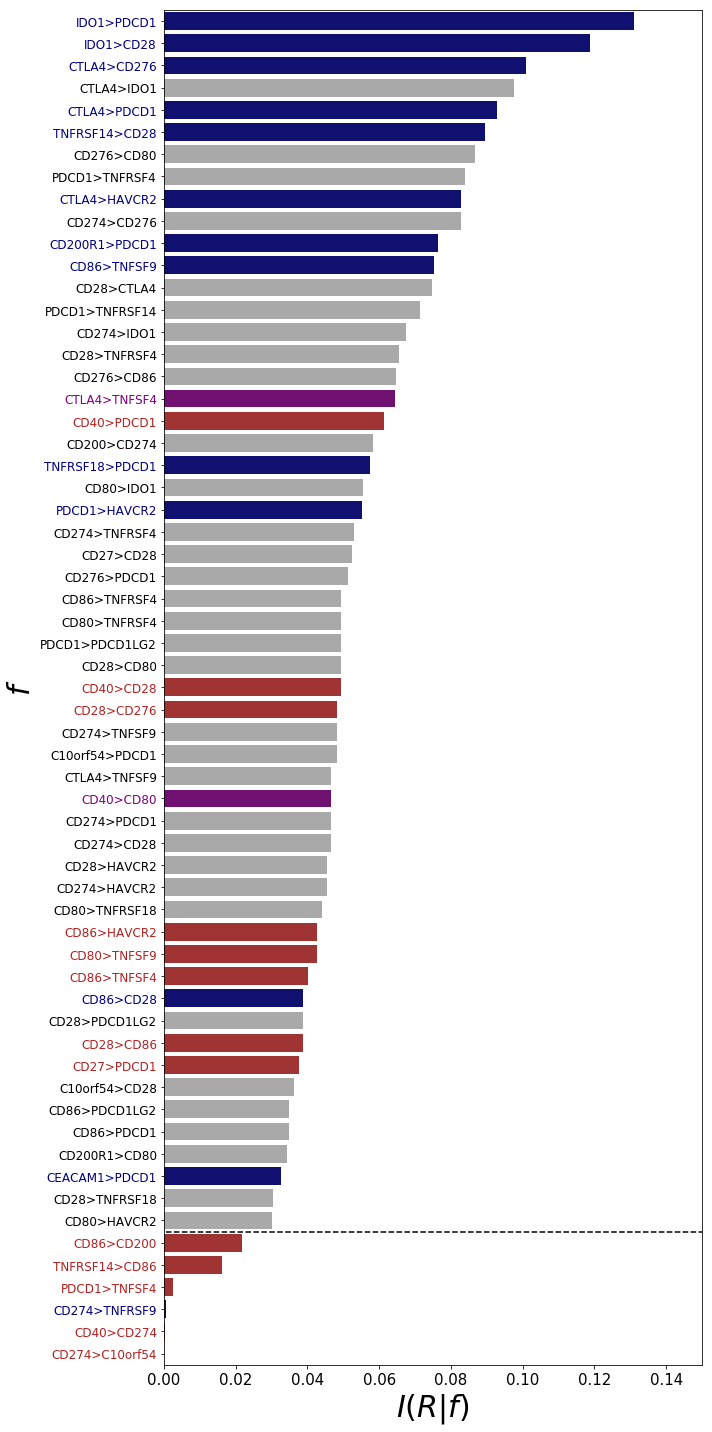

In [33]:
plt.figure(figsize=(10,20))
threshold=0.03
data=df.loc[features] #consider feature direction for impres and newsplits
data=data[(data.index.isin(impres)) | (data.index.isin(newsplits)) | (data.I>threshold)]
data.loc[:,'Feature_name']=data.index
data=data.sort_values(by=['I','Feature_name'],ascending=[False,False]) #sort by information, then by name for readability
plt.plot([-1,1],[np.where(data.I<threshold)[0][0]-.5,np.where(data.I<threshold)[0][0]-.5],'--k')
palette=[]
for x in data.index:
    if x in impres and x not in newsplits: #Impres only=red
        palette.append('Firebrick')
    elif x not in impres and x in newsplits: #newsplits only=blue
        palette.append('Navy')
    elif x in impres and x in newsplits: #both=purple
        palette.append('Purple')
    else: #neither=gray
        palette.append('DarkGray')
ax=sns.barplot(y=data.index,x=data.I,palette=palette)
plt.yticks(np.arange(len(data.index)),[x.replace('_','>') for x in data.index],fontsize=12)
plt.xticks(fontsize=15)
plt.xlabel(r'$I(R|f)$',fontsize=30)
plt.ylabel(r'$f$',fontsize=30)
plt.xlim([0,.15])
#Change color of yaxis labels
for i in np.where(np.array([1 if a in np.setdiff1d(impres,newsplits) else 0 for a in data.index])==1)[0]: 
    ax.get_yticklabels()[i].set_color("Firebrick")
for i in np.where(np.array([1 if a in np.setdiff1d(newsplits,impres) else 0 for a in data.index])==1)[0]: 
    ax.get_yticklabels()[i].set_color("Navy")
for i in np.where(np.array([1 if a in np.intersect1d(newsplits,impres) else 0 for a in data.index])==1)[0]: 
    ax.get_yticklabels()[i].set_color("Purple")
plt.tight_layout()
plt.savefig('./Letter_SFig1A'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

To understand how the use of random splits alters the IMPRES algorithm, we ran it 500 times to obtain 500 gene sets:

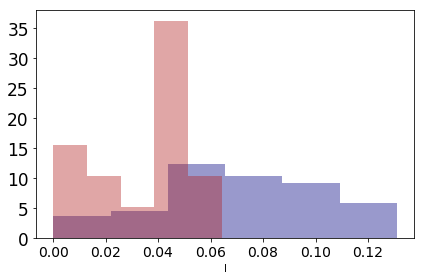

In [34]:
#Histogram showing amount of information in selected features across 500 different unbiased runs 
ax=sns.distplot(df.loc[(np.hstack(unbiased_splits))].I,kde=False,norm_hist=1,label='Unbiased',color='Navy',bins=6)
sns.distplot(df.loc[impres].I,ax=ax,kde=False,norm_hist=1,label='IMPRES',color='Firebrick',bins=5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=17)
plt.tight_layout()
plt.savefig('./Letter_SFig1B'+'.png',format='png', dpi=1200,transparent=True)

Mann-Whitney U p value: 0.0015


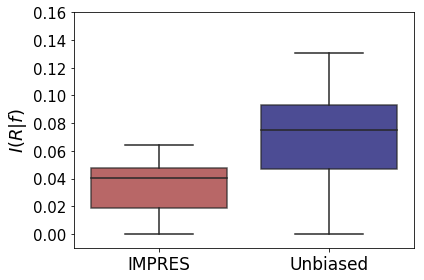

In [35]:
#Compare average information of features selected by IMPRES and unbiased IMPRES
values=np.hstack((df.loc[impres].I,df.loc[np.hstack(unbiased_splits)].I))
labels=np.hstack((['IMPRES']*len(impres),['Unbiased']*len(np.hstack(unbiased_splits))))
rank_compare=pd.DataFrame(np.vstack((values,labels)).T,columns=['ranks','set'])
rank_compare.ranks=rank_compare.ranks.astype(float)
sns.boxplot(x='set',y='ranks',data=rank_compare,palette=['Firebrick','Navy'],boxprops=dict(alpha=.75))
print(f'Mann-Whitney U p value: {np.round(stats.mannwhitneyu(df[df.index.isin(impres)].I,df[df.index.isin(newsplits)].I)[1],4)}')
plt.ylabel(r'$I(R|f)$',fontsize=18)
plt.xlabel('')
plt.ylim([-.01,.16])
plt.yticks(fontsize=15)
plt.xticks(fontsize=17)
plt.tight_layout()
plt.savefig('./Letter_SFig1C'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

Wilcoxon rank-sum p value: 0.0026


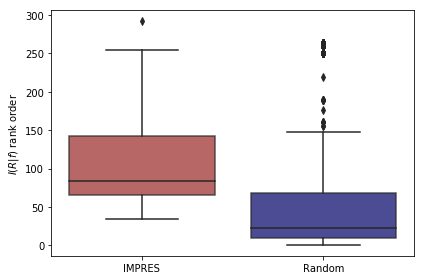

In [36]:
#Look at rank order (by MI) of features selected by IMPRES and the unbiased IMPRES algorithm
ranks=np.hstack((np.where(df.index.isin(impres))[0],[np.where(df.index==x)[0][0] for x in np.hstack(unbiased_splits)]))
labels=np.hstack((['IMPRES']*len(impres),['Random']*len(np.hstack(unbiased_splits))))
rank_compare=pd.DataFrame(np.vstack((ranks,labels)).T,columns=['ranks','set'])
rank_compare.ranks=rank_compare.ranks.astype(float)
sns.boxplot(x='set',y='ranks',data=rank_compare,palette=['Firebrick','Navy'],boxprops=dict(alpha=.75))
print(f'Wilcoxon rank-sum p value: {np.round(stats.ranksums(np.where(df.index.isin(impres))[0],np.where(df.index.isin(newsplits))[0])[1],4)}')
plt.ylabel(r'$I(R|f)$ rank order')
plt.xlabel('')
plt.tight_layout()
plt.savefig('./Letter_SFig1D'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

As expected from a theoretical point of view, running the IMPRES algorithm using randomly generated splits appears to select features in rough proportion to the amount of information (about NBL regression) provided by that feature. That is, the greedy algorithm of Auslander *et al* selects features in rough accordance to the amount of information that feature carries about NBL regression (which it is trained on) when provided with randomly generated splits. The fact that the original IMPRES features do not correlate with the amount of information provided about NBL strongly suggests that the non-random training sets introduces significant bias. 

Indeed, running the IMPRES algorithm 500 times and examining the number of times each feature is selected in the final feature set:

In [36]:
feature,counts=np.unique(np.hstack((unbiased_splits)),return_counts=1) #Number of times each feature is included in 
    #a final feature set (out of 500 total feature sets). Note that features are unique in each individual iteration.

In [37]:
#Some IMPRES features are selected 0 out of 500 times. To show this, add them in explicitly:
impres_notselected=np.setdiff1d(impres,feature) 
feature=np.hstack((feature,impres_notselected))
counts=np.hstack((counts,[0]*len(impres_notselected)))

In [38]:
idx=np.argsort(counts)[::-1] #sort features from high to low frequency
feature,counts=feature[idx],counts[idx]

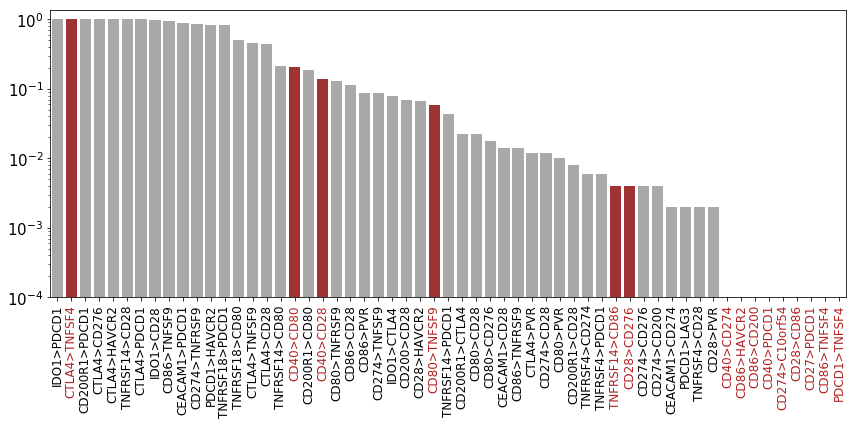

In [39]:
plt.figure(figsize=(12,6))
ax=sns.barplot(feature,counts/len(unbiased_splits),palette=['Firebrick' if x in impres else 'Darkgray' for x in feature])
plt.yscale('log')
plt.xticks(rotation=90)
for i in np.where(np.array([1 if x in impres else 0 for x in feature])==1)[0]: 
    ax.get_xticklabels()[i].set_color("Firebrick")
plt.xticks(np.arange(len(feature)),[x.replace('_','>') for x in feature],fontsize=12)
plt.yticks([1e-4,1e-3,1e-2,1e-1,1],fontsize=15)
plt.tight_layout()
plt.savefig('./Letter_Fig1A'+'.png',format='png', dpi=1200,transparent=True)

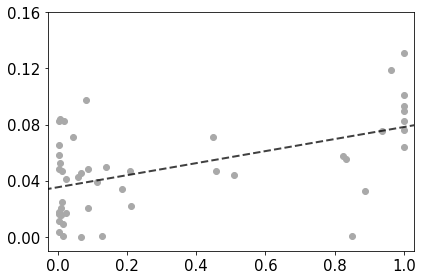

In [40]:
#Compare relationship between the fraction of unbiased feature sets a given feature is present in (x-axis) and 
    #the amount of information provided about NBL by that feature
feature,counts=np.unique(np.hstack((unbiased_splits)),return_counts=1)
plt.scatter(counts/len(unbiased_splits),df.loc[feature].I,color='DarkGray')
x=np.polyfit(counts/len(unbiased_splits),df.loc[feature].I,1)
p = np.poly1d(x)
plt.plot(np.arange(-.1,1.5,.01),p(np.arange(-.1,1.5,.01)),'--k',lw=2,alpha=.75)
plt.xlim([-.03,1.03])
plt.ylim([-.01,.15])
plt.xticks(fontsize=15)
plt.yticks(np.arange(0,.18,.04),fontsize=15)
plt.tight_layout()
plt.savefig('./Letter_SFig1E'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

In [42]:
stats.linregress(counts/500,df.loc[feature].I) #linear regression of above plot

LinregressResult(slope=0.042911024920809705, intercept=0.035343780289704044, rvalue=0.5286274558059528, pvalue=0.00011232400027420034, stderr=0.010159520836478851)

## Source of bias in original IMPRES feature selection

To better understand these findings, we next examined the [provided splits](https://github.com/noamaus/IMPRES-codes/tree/master/MAIN_CODES/Feature_selection) (FOLDS.mat):

In [43]:
STSP=pd.DataFrame(np.genfromtxt(fileroot+'Auslander/Splits/STSP.txt',dtype='unicode',delimiter=',').astype(float).T)
STSN=pd.DataFrame(np.genfromtxt(fileroot+'Auslander/Splits/STSN.txt',dtype='unicode',delimiter=',').astype(float).T)
STP=pd.DataFrame(np.genfromtxt(fileroot+'Auslander/Splits//STP.txt',dtype='unicode',delimiter=',').astype(float).T)
STN=pd.DataFrame(np.genfromtxt(fileroot+'Auslander/Splits/STN.txt',dtype='unicode',delimiter=',').astype(float).T)

Surprisingly, we find that a large number of splits are actually repeated (including the order of samples in each split):

In [44]:
print(f'Responders: {STSP.drop_duplicates().shape[0]} unique splits out of {STSP.shape[0]} total splits')
print(f'Non responders: {STSN.drop_duplicates().shape[0]} unique splits out of {STSN.shape[0]} total splits')
print(f'Total unique splits (full training set=responders+nonresponders): {pd.DataFrame(np.hstack((STSP,STSN))).drop_duplicates().shape[0]}')

Responders: 404 unique splits out of 500 total splits
Non responders: 404 unique splits out of 500 total splits
Total unique splits (full training set=responders+nonresponders): 404


Conserved splits are:

In [45]:
df=pd.DataFrame(np.hstack((STSP,STSN)))
df = df[df.duplicated(keep=False)]
tuple_groups=df.groupby(df.columns.tolist()).apply(lambda x: tuple(x.index)).tolist()
count_dist=np.hstack((np.array([len(x) for x in tuple_groups]),[1]*np.setdiff1d(np.arange(500),np.hstack(tuple_groups)).shape[0]))
unique,counts=np.unique(count_dist,return_counts=1)
countdf=pd.DataFrame(np.vstack((unique,counts,['IMPRES']*len(unique))).T)
display(tuple_groups)

[(150, 195, 497),
 (12, 88),
 (190, 475),
 (298, 340),
 (375, 411),
 (28, 94, 200),
 (295, 305, 356),
 (78, 115, 208),
 (0, 483),
 (391, 424),
 (473, 485),
 (21, 92),
 (128, 154, 191),
 (116, 209),
 (76, 114),
 (387, 421),
 (37, 476),
 (42, 203),
 (378, 415),
 (147, 194),
 (299, 341, 352),
 (102, 202, 496),
 (66, 206),
 (27, 93, 153, 197),
 (395, 427),
 (301, 308, 348, 359),
 (36, 100, 201),
 (10, 86),
 (309, 314),
 (98, 189),
 (65, 111),
 (288, 322, 350, 491),
 (347, 490),
 (172, 438),
 (7, 82),
 (11, 87),
 (364, 403),
 (24, 474),
 (30, 97),
 (313, 318),
 (131, 192),
 (297, 306, 357),
 (9, 84),
 (329, 499),
 (38, 101),
 (73, 207),
 (382, 419),
 (372, 407),
 (376, 412),
 (75, 113),
 (20, 91),
 (81, 210),
 (307, 358),
 (62, 110),
 (390, 422),
 (29, 95),
 (292, 303, 325, 351, 355),
 (310, 315),
 (366, 405),
 (45, 104),
 (52, 477),
 (13, 152, 187, 472, 484),
 (198, 495),
 (294, 331),
 (394, 426),
 (63, 481),
 (290, 302, 354),
 (312, 317),
 (14, 89),
 (74, 112),
 (54, 107, 155, 193),
 (311

**Note that, in Python, indexing begins with 0. In MATLAB, they are indexed from 1. The provided splits are thus each 1 less than those found in the MATLAB files**

And for randomly generated splits:

In [46]:
random_tsn=pd.DataFrame(np.genfromtxt(fileroot+'Unbiased IMPRES/NonRegressing_Splits.txt',dtype='unicode',delimiter=',').astype(float).T.reshape(500,13))
random_tsp=pd.DataFrame(np.genfromtxt(fileroot+'Unbiased IMPRES/Regressing_Splits.txt',dtype='unicode',delimiter=',').astype(float).T.reshape(500,13))

In [47]:
print(f'Responders: {random_tsp.drop_duplicates().shape[0]} unique splits out of {random_tsp.shape[0]} total splits')
print(f'Non responders: {random_tsn.drop_duplicates().shape[0]} unique splits out of {random_tsn.shape[0]} total splits')
print(f'Total unique splits (full training set=responders+nonresponders): {pd.DataFrame(np.hstack((random_tsp,random_tsn))).drop_duplicates().shape[0]}')

Responders: 500 unique splits out of 500 total splits
Non responders: 500 unique splits out of 500 total splits
Total unique splits (full training set=responders+nonresponders): 500


And plotting the "clone" size of each training set:

In [48]:
countdf=countdf.append(pd.DataFrame([1,500,'Expected']).T)
countdf.columns=['Count','Frequency','Type']
countdf[['Frequency']]=countdf[['Frequency']].astype(float)
countdf[['Count']]=countdf[['Count']].astype(str)
countdf.Count=['One','two','three','four','five','One']

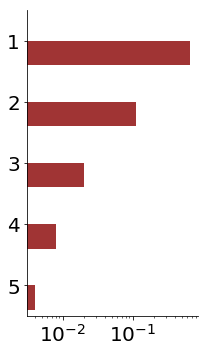

In [49]:
plt.figure(figsize=(3,5))
sns.barplot(countdf.Frequency/500,countdf.Count,hue=countdf.Type,hue_order=['Unbiased','IMPRES'],palette=['Navy','Firebrick'])
plt.xscale('log')
sns.despine()
plt.yticks(np.arange(5),np.arange(1,6),fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.legend('',frameon=False,fontsize=15)
plt.tight_layout()
plt.savefig('./Letter_Fig1B'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

### Probability of observing repeated training sets

When we generate a training set, we first pick 13 spontaneous regressing NBL patients from 92 total regressing samples. If we consider the order in which we draw these samples, the total number of combinatoric permutations is:

$$
\begin{array}
\
P_R(n,r) &=& \displaystyle \frac{n!}{(n-r)!} &=& \displaystyle \frac{92!}{(92-13)!}  \approx \displaystyle 1.4\times10^{25}
\end{array}
$$

We next want to calculate the probability of drawing two identical permutations in 500 iterations. Alternatively stated, we wish to know the probability of selecting the same number twice when randomly drawing 500 numbers from a list ranging from 0 to $1.4\times10^{25}$.

In this formulation, we want to know the probability that at least one number is drawn twice. Given that either all drawn numbers are different ($p_R(A)$) or at least one number is drawn more than once ($p_R(A')$), we observe that $p_R(A)=1-p_R(A')$. Then:


$$
\begin{array}
\
p_R(A') &=& \displaystyle \frac{P_R(n,r)}{P_R(n,r)} \times \frac{P_R(n,r)-1}{P_R(n,r)} \times \ldots \times \frac{P_R(n,r)-499}{P_R(n,r)}
\end{array}
$$

And:

$$
\begin{array}
\
p_R(A)&=& \displaystyle 1-p_R(A') \approx\displaystyle 8.9 × 10^{-22}
\end{array}
$$


Similiarly, the probability of selecting 13 identical patients from 16 total non-regressing NBL patients gives $3.5\times10^{12}$ permutations and $p_{NR}(A)=3.6\times10^{-9}$.

The probability of choosing any training set more than once through 500 iterations is thus bounded above by $\approx 3.2\times10^{-30}$.

Despite the miniscule probability of observing the same training set (in the same order) more than once through 500 iterations, the IMPRES feature selection used had 56 training sets that were observed twice, 10 training sets that were used three times, 4 training sets used fours times, and 2 training sets used five times. 

Consequently, the probability that the training sets used to select the IMPRES features were randomly generated approaches zero. 

## Impact of using biased training sets 
While the IMPRES feaures were not selected using an unbiased machine learning algorithm, it is possible the the corrected algorithm (*i.e.* one using truly randomly generated splits) will still allow for the selection of informative features in the melanoma dataset. Indeed, if the underlying biological hypothesis is correct, namely that spontaneous NBL regression and melanoma response to immunotherapy are mediated by similiar mechanisms, we would expect that the features selected by the corrected IMPRES algorithm will still have predictive power in the NBL set. 

As such, we next examined the ability of our new IMPRES features to predice melanoma response:

### Unbiased IMPRES algorithm and melanoma response prediction

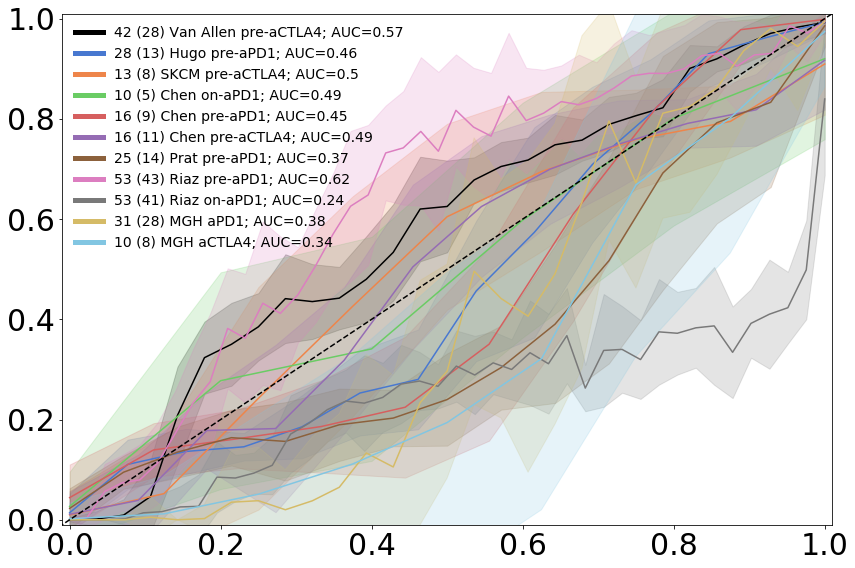

In [50]:
#ROC curves for each dataset individually, averaged over 500 unbiased feature sets
palette=sns.color_palette("muted")
palette.append('k')
palette=np.hstack(('k',np.array(palette)[:-1]))
collectaucs=[] 
plt.figure(figsize=(12,8))

#Names for legend
name=['Van Allen pre-aCTLA4','Hugo pre-aPD1','SKCM pre-aCTLA4','Chen on-aPD1','Chen pre-aPD1','Chen pre-aCTLA4','Prat pre-aPD1','Riaz pre-aPD1','Riaz on-aPD1','MGH aPD1','MGH aCTLA4']

#for each dataset
for i,data in enumerate(['VanAllen','Hugo','SKCM','Wargo_onPD1','Wargo_prePD1','Wargo_preCTLA4','Felip','Riaz','Riaz_on','MGH_pd1','MGH_ctla4']):
    df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl') #read data
    fprs,tprs,aucs=[],[],[] 
    for gene_set in unbiased_splits: #for each unbiased feature set
        df=calculate_impres(df,gene_set) #calculate score for each sample using that particular unbiased feature set
        fpr,tpr,auc,n_res,n_nres=calculate_auc(df) #calculate auc from score
        fprs.append(fpr),tprs.append(tpr),aucs.append(auc) #save pair tpr/fpr vectors, aucs
    collectaucs.append(aucs) #all aucs for boxplot
    #plot average auc, shaded region is standard deviation between 500 feature sets
    sns.lineplot(np.hstack(fprs),np.hstack(tprs),color=palette[i],ci='sd',label=f'{n_res+n_nres} ({n_nres}) {name[i]}; AUC={np.round(np.mean(aucs),2)}')
plt.plot([-1,2],[-1,2],'--k') # Plot line expected by random guessing
leg=plt.legend(loc='upper left',frameon=False,fontsize=14) #plt legend
for legobj in leg.legendHandles: #set legend size
    legobj.set_linewidth(5.0)
plt.ylim([-0.01,1.01])
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig('./Letter_SFig2A'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

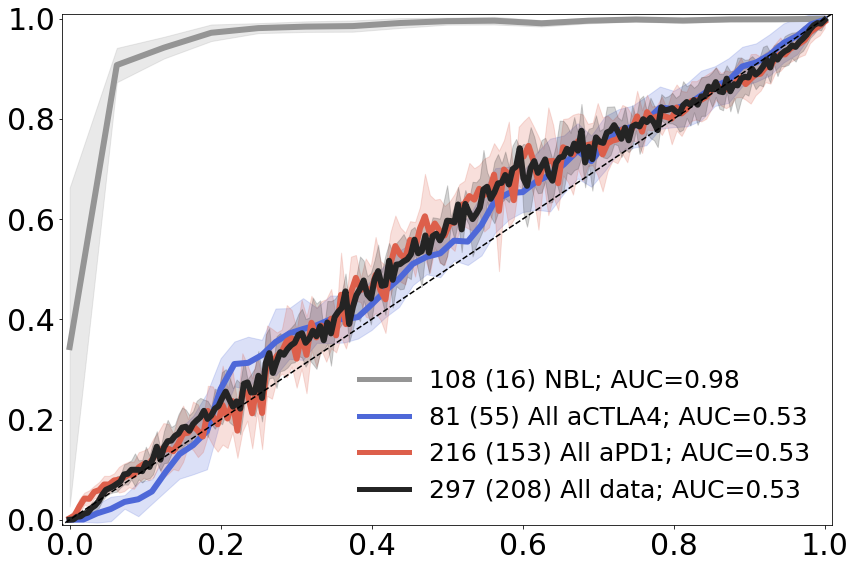

In [51]:
#ROC curves for NBL and all melanoma datasets, averaged over 500 unbiased feature sets
name=['NBL','All aCTLA4','All aPD1','All data']
palette1 = sns.color_palette("coolwarm",15)
palette2 = sns.color_palette("Greys",15)
palette=np.vstack((np.array(palette1)[np.array([0,13])],np.array(palette2)[np.array([7,13])]))
palette=palette[np.array([2,0,1,3])]
plt.figure(figsize=(12,8))
for i,data in enumerate(['NBL','CTLA4','PD1','All']):
    if data=='All': #All melanoma samples
        df=all_data
    elif data=='NBL': #NBL samples
        df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    else: #All CTLA4 or all PD1 samples
        df=all_data[all_data.immunotherapy_type==data]
    fprs,tprs,aucs=[],[],[]
    for gene_set in unbiased_splits: #for 500 unbiased feature sets
        df=calculate_impres(df,gene_set) #calculate score for each sample
        fpr,tpr,auc,n_res,n_nres=calculate_auc(df) #calculate ROC auc for that feature sets
        fprs.append(fpr),tprs.append(tpr),aucs.append(auc) #save fpr/tpr pairs, as well as aucs
    collectaucs.append(aucs)
    #Plot average ROC curve. STD between 500 unbiased feature sets shown as shaded region
    sns.lineplot(np.hstack(fprs),np.hstack(tprs),color=palette[i],ci='sd',label=f'{n_res+n_nres} ({n_nres}) {name[i]}; AUC={np.round(np.mean(aucs),2)}',lw=6)
plt.plot([-1,2],[-1,2],'--k') #random guessing
leg=plt.legend(loc='lower right',frameon=False,fontsize=25) #plt legend
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.ylim([-0.01,1.01])
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig('./Letter_Fig1D'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

In [52]:
#Create dataframe containing AUCs for each melanoma dataset individually, for each of the 500 unbiased feature sets
names=['Van Allen pre-aCTLA4','Hugo pre-aPD1','SKCM pre-aCTLA4','Chen on-aPD1','Chen pre-aPD1','Chen pre-aCTLA4','Prat pre-aPD1','Riaz pre-aPD1','Riaz on-aPD1','MGH aPD1','MGH aCTLA4','NBL','All aCTLA4','All aPD1','All data']
for i in range(len(collectaucs)):
    if i==0:
        df=pd.DataFrame(np.vstack((collectaucs[i],[names[i]]*len(collectaucs[i]))).T)
    else:
        df=df.append(pd.DataFrame(np.vstack((collectaucs[i],[names[i]]*len(collectaucs[i]))).T))
df.columns=['AUC','Dataset']
df.AUC=df.AUC.astype(float)
data=df[~df.Dataset.isin(['NBL','All aCTLA4','All aPD1','All data'])]
order=[]
for x in np.unique(data.Dataset):
    order.append(data[data.Dataset==x].AUC.mean())

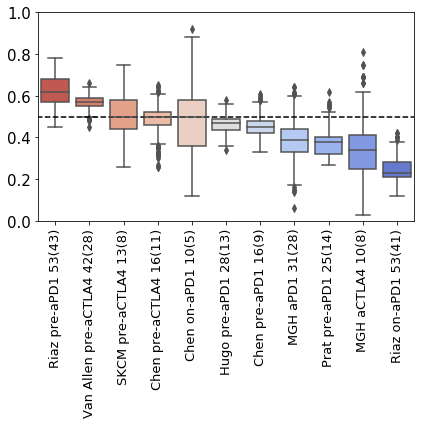

In [53]:
#Boxplots shwoing AUC for ROC curves across each melanoma dataset, taken from 500 unbiased feature sets
plt.figure(figsize=(6,6))
sns.boxplot(x='Dataset',y='AUC',data=data,order=np.unique(data.Dataset)[np.argsort(order)[::-1]],palette='coolwarm_r')
plt.xticks(rotation=90,fontsize=13,ha='center')
plt.yticks(fontsize=15)
plt.ylabel('')
plt.xlabel('')
plt.plot([-1,15],[0.5,.5],'--k')
plt.ylim([0,1])
plt.xticks(np.arange(len(np.unique(data.Dataset))),[x + ' '+y for x,y in zip(np.unique(data.Dataset)[np.argsort(order)[::-1]],
                     ['53(43)','42(28)','13(8)','16(11)','10(5)','28(13)','16(9)','31(28)','25(14)','10(8)','53(41)'])])
plt.tight_layout()
plt.savefig('./Letter_Fig1C'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

#### Recall/precision curves for unbiased IMPRES algorithm:

In [54]:
for i,gene in enumerate(unbiased_splits):
    data=[]
    df=all_data
    df=calculate_impres(df,gene)
    for threshold in range(5,14):
        responders,scores=[1 if x=='Responder' else 0 for x in df.Labels],[1 if x>=threshold else 0 for x in df.IMPRES]
        if np.sum(scores)>0 and np.sum(scores)<len(df.IMPRES):
            r=recall_score([1 if x=='Responder' else 0 for x in df.Labels],[1 if x>=threshold else 0 for x in df.IMPRES])
            p=precision_score([1 if x=='Responder' else 0 for x in df.Labels],[1 if x>=threshold else 0 for x in df.IMPRES])
            data.append([threshold,r,p])
    if i==0:
        rpdf=pd.DataFrame(np.vstack((data)),columns=['Score','Recall','Precision'])
    else:
        rpdf=rpdf.append(pd.DataFrame(np.vstack((data)),columns=['Score','Recall','Precision']))

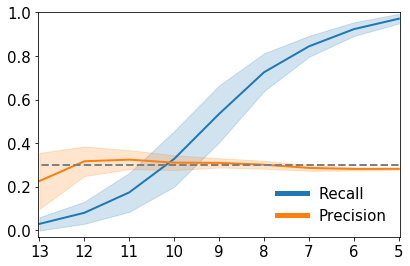

In [55]:
sns.lineplot(13-rpdf.Score,rpdf.Recall,ci='sd',lw=2,label='Recall')
sns.lineplot(13-rpdf.Score,rpdf.Precision,ci='sd',lw=2,label='Precision')
leg=plt.legend(frameon=False,fontsize=15,loc='lower right')
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.yticks(fontsize=15)
plt.xticks(np.arange(9),np.arange(5,14)[::-1],fontsize=15)
plt.ylim([-.03,1])
plt.plot([-1,9],[.3,.3],'--',color='Gray',lw=2)
plt.xlim([-.03,8.03])
plt.tight_layout()
plt.ylabel('')
plt.xlabel('')
plt.savefig('./Letter_SFig2B'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

#### Examining TP/FP rates:

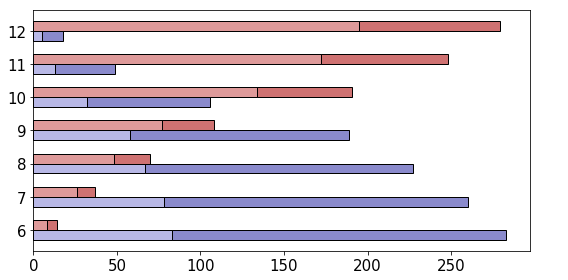

In [56]:
#Calculating TP/FP/TN/FN rates for all melanoma samples as done for IMPRES above
df=all_data
df=calculate_impres(df,newsplits)
data=[]
for threshold in range(6,13):
    TP=df[(df.Labels=='Responder') & (df.IMPRES>=threshold)].shape[0]
    FP=df[(df.Labels=='NonResponder') & (df.IMPRES>=threshold)].shape[0]
    FN=df[(df.Labels=='Responder') & (df.IMPRES<threshold)].shape[0]
    TN=df[(df.Labels=='NonResponder') & (df.IMPRES<threshold)].shape[0]
    data.append([threshold,TP,FP,FN,TN])
df=pd.DataFrame(data,columns=['Threshold','TP','FP','FN','TN'])
df1=df[['TP','FP']]
df2=df[['TN','FN']]
df2.columns=['TP','FP']
df1.index=df.Threshold
df2.index=df.Threshold
comp = build_comparison_table([df2, df1], ['Positive', 'Negative'], fillna=0.0)
ax, fig = plot_grouped_stackedbars(comp, ix_categories='Criteria', ix_entities_compared='Scenarios', norm=None,palette_def=[sns.light_palette("firebrick")[-4::],sns.light_palette("navy")[-5::]])
plt.savefig('./Letter_SFig2C'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

### Unbiased IMPRES algorithm and melanoma survival analyses

Checking whether the IMPRES algorithm with random splits is still able to predict survival in the melanoma datasets:

(21, 3)
(37, 3)
<lifelines.StatisticalResult>
               t_0 = -1
             alpha = 0.99
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  log(p)   
          0.75 0.39   -0.95
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


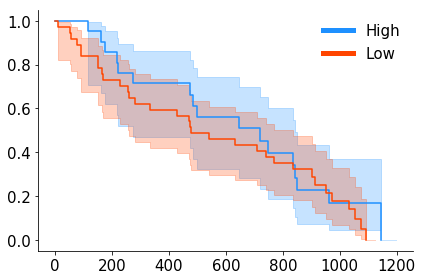

In [57]:
kaplan_meier('Riaz',newsplits,'Letter_Fig1F')

(16, 3)
(26, 3)
<lifelines.StatisticalResult>
               t_0 = -1
             alpha = 0.99
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  log(p)   
          0.13 0.72   -0.33
---
Signif. codes: 0 '***' 0.0001 '**' 0.001 '*' 0.01 '.' 0.05 ' ' 1


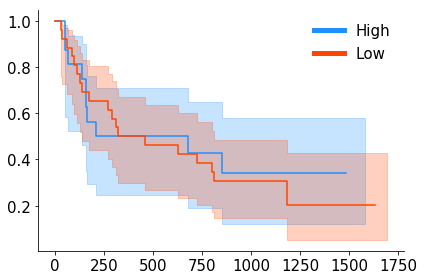

In [58]:
kaplan_meier('VanAllen',newsplits,'Letter_Fig1G')

[13 29]


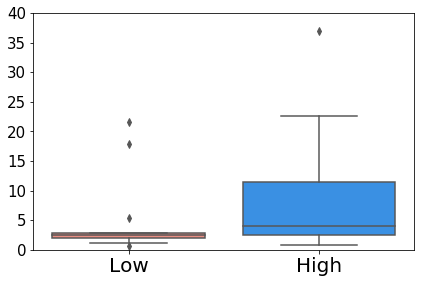

p value: 0.04325876314116403


In [59]:
pfs_plot('VanAllen',newsplits,fig='SFig3D')

[10 15]


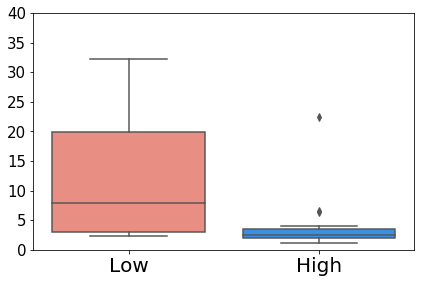

p value: 0.011474854705547996


In [60]:
pfs_plot('Felip',newsplits,fig='SFig3E')

## Correlation between considered immune features for NBL regression and melanoma response

The finding that features selected using random splits for feature selection predict the NBL dataset with an AUC of nearly 1. This is unsurprising given that our features were selected in a way that maximizes the information about the same NBL dataset, but it does raise more questions as to why the IMPRES features performed poorly on the NBL set. 

More specifically, it appears as though the original IMPRES features were selected in a manner that actually biased them to underfit the NBL data. However, this would be methododically inconsistent with the use of a greedy algorithm trained exclusively NBl and biologically with the finding that NBL features directly transferable to melanoma immunotherapy. 

To better understand the relationship between the generalizability of NBL pairwise interactions to melanoma datasets, we calculated Mathew's Correlation Coefficent ($\phi$):

$$
\begin{array}
\
\phi &=& \displaystyle \frac{(TP*TN)-(FN*FP)}{\sqrt{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}}
\end{array}
$$

TP=true positvie, TN= true negative, FP= false positive, FN=false negative. 

Thus $\phi$ is a correlation coefficent bounded by $\pm1$ with the strength and direction of the correlation represented by the distance form 0. 

In [61]:
#Calculating phi for NBL and all melanoma samples
for i,data in enumerate(['NBL','All']):
    if data=='All': #All melanoma
        df=all_data
    else: #NBL data
        df=pd.read_pickle(fileroot+'/Auslander/'+data+'_data.pkl')
    survivor=df[df['Labels']=='Responder']
    nonsurvivor=df[df['Labels']=='NonResponder']
    phi=[]
    for x,y in impres_consider:
        a=sum(1*(survivor[x]>survivor[y])) #Responder with feautre
        b=sum(1*(nonsurvivor[x]>nonsurvivor[y])) #Nonresponder with feature
        c=survivor.shape[0]-a #Responders without feature
        d=nonsurvivor.shape[0]-b #nonresponders without feature
        if (a+b>0) & (c+d>0):
            phi.append(((a*d)-(b*c))/np.sqrt(((a+b)*(a+c)*(b+d)*(c+d)))) #Phi definition
        else:
            phi.append(0)
    if i==0:
        all_phi=phi
    else:
        all_phi=np.vstack((all_phi,phi))  

In [62]:
df=pd.DataFrame(all_phi.T,columns=['NBL','All'],index=[x+'_'+y for x,y in impres_consider])
df=df.astype(float)
pos=np.array([1 if x>=0 else -1 for x in df.NBL]) #Define phi values to be positive for NBL
for data in ['NBL','All']: #Convert NBL and melanoma features such that correlation direction is positive in NBL
    df[data]=df[data]*pos 

In [63]:
impres_consider_unique=[]
for i,x in enumerate(immune_genes):
    for y in immune_genes[i+1:]:
        if x in checkpoint or y in checkpoint:
            impres_consider_unique.append([x,y])
impres_consider_unique=np.array(impres_consider_unique)
impres_consider_unique=[x+'_'+y for x,y in impres_consider_unique]

LinregressResult(slope=0.14491017381215732, intercept=-0.006225519223295881, rvalue=0.12388427776799482, pvalue=0.1349249888262201, stderr=0.09639182832050368)


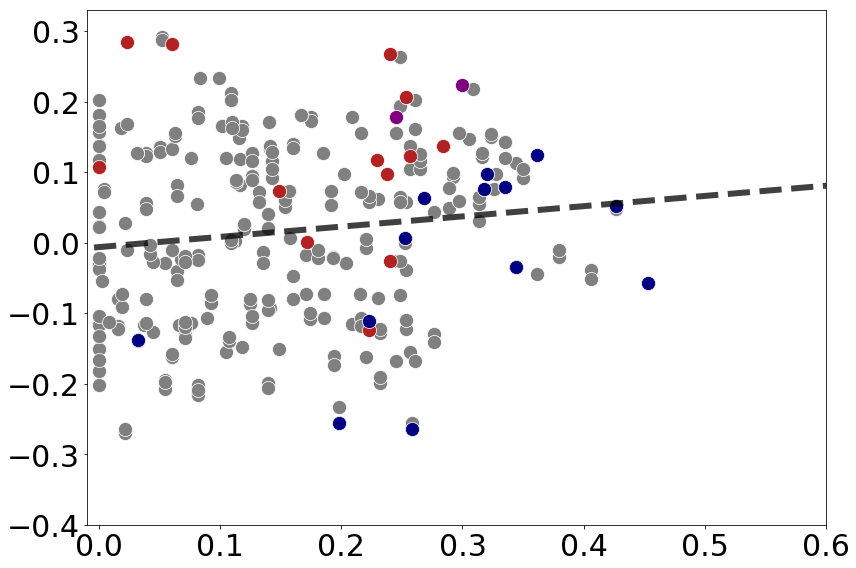

IMPRES: 13 positively correlated features vs. 2 negatively correlated
NewSplit: 9 positively correlated features vs. 6 negatively correlated
All considered features: 79 positively correlated features vs. 68 negatively correlated


In [64]:
#Calculate correlation between NBL and melanoma phi values
plt.figure(figsize=(12,8))
for data in ['All']:
    #Linear regression fit
    x=np.polyfit(df.loc[impres_consider_unique].NBL.astype(float),df.loc[impres_consider_unique][data].astype(float),1)
    p = np.poly1d(x)
    plt.plot(np.arange(-.5,.7,.01),p(np.arange(-.5,.7,.01)),'--k',lw=6,alpha=.75) #plot best fit line
    s=200 #scatter point size
    sns.scatterplot(df.NBL.astype(float),df[data].astype(float),color=['Grey'],s=s) #scatter NBL
    sns.scatterplot(df.NBL.loc[np.setdiff1d(impres,newsplits)].astype(float),df[data].loc[np.setdiff1d(impres,newsplits)].astype(float),color=['Firebrick'],s=s) #Scatter IMPRES only
    sns.scatterplot(df.NBL.loc[np.setdiff1d(newsplits,impres)].astype(float),df[data].loc[np.setdiff1d(newsplits,impres)].astype(float),color=['Navy'],s=s) #Scatter newsplits only
    sns.scatterplot(df.NBL.loc[np.intersect1d(impres,newsplits)].astype(float),df[data].loc[np.intersect1d(impres,newsplits)].astype(float),color=['Purple'],s=s) #scatter IMPRES and newsplits
    plt.xlim([-.01,.6])
    plt.ylim([-.4,.33])
    plt.yticks(fontsize=30)
    plt.xticks(fontsize=30)
    plt.ylabel('')
    plt.xlabel('')
    #Print linear regression results
    print(stats.linregress(df.loc[impres_consider_unique].NBL.astype(float),df.loc[impres_consider_unique][data].astype(float)))
    plt.tight_layout()
    plt.savefig('./Letter_FigH'+'.png',format='png', dpi=1200,transparent=True)
    plt.show()
    plt.close()
    print(f'IMPRES: {sum(1*(df.loc[impres][data]>=0))} positively correlated features vs. {sum(1*(df.loc[impres][data]<0))} negatively correlated')
    print(f'NewSplit: {sum(1*(df.loc[newsplits][data]>=0))} positively correlated features vs. {sum(1*(df.loc[newsplits][data]<0))} negatively correlated')
    print(f'All considered features: {sum(1*(df.loc[impres_consider_unique][data]>=0))} positively correlated features vs. {sum(1*(df.loc[impres_consider_unique][data]<0))} negatively correlated')

In [65]:
#Odds ratio/Fisher's exact p value for enrichment of features correlated with melanoma in IMPRES vs. all features
OR,p=stats.fisher_exact([[13,79],[2,68]])
print(f'Odds ratio for positive correlation in IMPRES: {OR}')
print(f'p value for assoring randomly: {p}')

Odds ratio for positive correlation in IMPRES: 5.594936708860759
p value for assoring randomly: 0.014497445645289847


The central hypothesis of the Auslander *et al* paper is that the features which predict spontaneous regression in NBL are conserved in melanoma immunotherapy. We have already shown that the use of none random training splits during the selection of IMPRES features introduced a strong bias. When truly random training and test splits were used in the same algorithm, selected features were more predictive of NBL but had no predictive value in melanoma. 

The results presented in this section demonstrate that training on NBL for prediction in melanoma is inherently flawed. More specifically, the 147 unique features considered by Auslander *et al*, which were thought to accurately capture the immune response, demonstrate no conservation between NBL and melanoma. Specifically, using $\phi$ as a rough correlation for the amount of information contained about tumor response, we found no relationship between NBL and melanoma ($R^2=0.015$, $p=0.13$ by 2-sided Wald's test against slope of zero). These findings strongly suggest that there is no correlation between the considered NBL and melanoma features and strongly suggest machine learning should not be capable of learning informative features for melanoma from NBL within the available datasets. 

Furthermore, the sucess of the original IMPRES features stems from the unlikely selection of those features which are generaly conserved between NBL and melanoma (OR=5.6, probabilty of randomly IMPRES randomly selecting that number of generalizable features is about 1.5\% by Fisher's exact test). 

The probability of randomly selecting a set of features that outperforms IMPRES on melanoma prediction is likely substantially lower than this given the strength of positively correlate features and weakeness of the negatively correlated features:

In [66]:
means=[]
for split in unbiased_splits: #for 500 unbiased feature sets
    means.append(np.mean(df.loc[split].All)) #calculate mean melanoma phi value for feature set

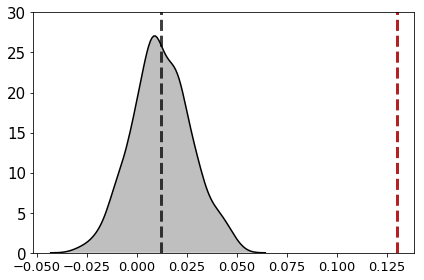

In [67]:
plt.figure(figsize=(6,4))
sns.kdeplot(means,shade=True,color='k') #kde plot showing distribution of mean melanoma phi values in unbiased feature sets
plt.plot([np.mean(df.loc[impres].All),np.mean(df.loc[impres].All)],[0,40],'--',lw=3,color='Firebrick') #IMPRES average feature set
plt.plot([np.mean(means),np.mean(means)],[0,40],'--',lw=3,color='k',alpha=.75) #mean unbiased feature set melanoma phi
plt.ylim([0,30])
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./Letter_FigH2'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

In [68]:
print(f'500 iterations mean phi: {np.mean(means)} +/- {np.std(means)}')
print(f'IMPRES mean phi: {np.mean(df.loc[impres].All)} ({np.round(np.mean((df.loc[impres].All)-np.mean(means))/np.std(means),2)} standard deviations above mean)')

500 iterations mean phi: 0.01219303787584951 +/- 0.014655956110142474
IMPRES mean phi: 0.1299025504232794 (8.03 standard deviations above mean)


## In summary, our results demonstrate that:

1. Non-random training and testing sets introduced significant biases into the selection of the IMPRES features. 

2.  Use of truly random training/test splits results in different features being selected. Feature sets generated using the corrected implementation of the IMPRES algorithm have no predictive value in melanoma. 

3. The information contained within NBL pairwise interactions is not readily generalizable to melanoma ICB response (for the 294 considered immune features). 

Consequently, although IMPRES possesses impressive predictive power for the published melanoma datasets available, it appears as though the creation of IMPRES was statistically flawed. Potentially, the non-random training and testing sets biased IMPRES feature selection towards of informative features an resulted in a statistcally improbable set of features with predictive power. Alternatively, IMPRES features were selected without being first blinded to the melanoma datasets (*i.e.* IMPRES has actually been overfit with respect to the melanoma dataset). In either case, these findings bring serious questions about the validity of IMPRES and suggest that predictions made by IMPRES may not be readily generalizable to other melanoma datasets. 

### IMPRES on an independent GBM dataset

Since the publication of IMPRES, [Zhao *et al.*](https://www.nature.com/articles/s41591-019-0349-y) published a new glioblastoma (GBM) dataset in the context of ICB therapy. Downloading the raw RNA sequencing data for these GBM samples and again quantifying RNA expression using Kallisto:

In [69]:
GBM=pd.read_csv(fileroot+'GBM TPM/GBM_tpm.csv') #Hugo pre-therapy
GBM.index=np.array(GBM['sample'])
GBM=GBM.drop(columns=['sample'])
GBM=calculate_impres(GBM,impres_tpm)

In [70]:
#GBM metadata obtained from Junfei Zhao
gbm_key=pd.DataFrame(np.genfromtxt(fileroot+'GBM TPM/GBM_key.txt',dtype='unicode'),columns=['Patient','ID','Response'])
gbm_key.index=gbm_key.ID

In [71]:
#Combine with clinical response from Zhao et al. Supplemental Table 1
gbm_table=pd.read_csv(fileroot+'GBM TPM/GBM_runtable.txt',delimiter='\t')[['Assay_Type','Sample_Name','Run']]
gbm_table=gbm_table[gbm_table.Assay_Type=='RNA-Seq']
gbm_table.index=np.array(gbm_table.Sample_Name)

gbm_table['Labels']=[gbm_key.loc[x].Response for x in gbm_table.index]
gbm_table.Labels=['Responder' if x=='Yes' else 'NonResponder' for x in gbm_table.Labels]
gbm_table.index=gbm_table.Run

#Add clinical outcome to GBM samples
GBM['Labels']=gbm_table.loc[GBM.index].Labels #

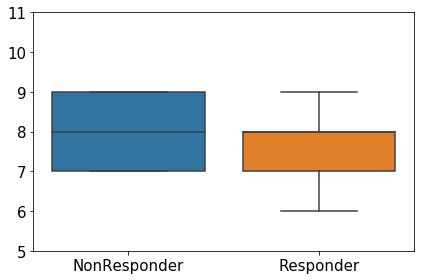

In [72]:
sns.boxplot(x='Labels',y='IMPRES',data=GBM)
plt.ylim([5,11])
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./Letter_SFig4C'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()

In [73]:
#p value
stats.ranksums(GBM[GBM.Labels=='Responder'].IMPRES,GBM[GBM.Labels=='NonResponder'].IMPRES)

RanksumsResult(statistic=-0.5683182777759105, pvalue=0.5698188702093101)

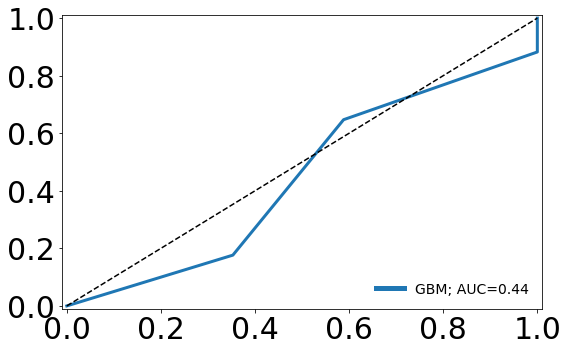

In [74]:
plt.figure(figsize=(8,5))
name=['GBM']
for i,df in enumerate([GBM]):
    fpr,tpr,auc,n_res,n_nres=calculate_auc(df) 
    plt.plot(fpr,tpr,label=f'{name[i]}; AUC={auc}',lw=3)
plt.plot([0,1],[0,1],'--k')
leg=plt.legend(loc='lower right',frameon=False,fontsize=14) 
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
plt.ylim([-0.01,1.01])
plt.xlim([-0.01,1.01])
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.tight_layout()
plt.savefig('./Letter_SFig4B'+'.png',format='png', dpi=1200,transparent=True)
plt.show()
plt.close()